# Predcition of Hospital Admission Related to Combination of Upper Respiratory Tract Infections 

In this notebook, we develop Cox proportional hazard regression models to predict the risk of hospital admission related to combination of Upper Respiratory Tract Infections (urti_combined). We, then, analyse whether prescribing antibiotics is based on the risk of hospital admission or not by building logistic regression (LR) and random forest (RF) models.

In [13]:
import pandas as pd
import matplotlib
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
import numpy as np
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve, roc_auc_score
import statsmodels.api as sm
from scipy import stats
from statsmodels.formula.api import logit
from datetime import date
from operator import attrgetter
import io
from contextlib import redirect_stdout
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

## 0- functions

In [14]:
#function to transform cph model summary and save it as html
def GetPrintSummary(model):
    output = ""
    with io.StringIO() as buf, redirect_stdout(buf):
        model.print_summary(style="html")
        output = buf.getvalue()
    return output

In [15]:
#round counts in a way that the last digit become 0 or 5
def round_five_mul(x, base=5):
    return base * round(x/base)

In [16]:
#function to process urti_combined data
def proc_infec_data_combined_urti(data, infection):
    #rename variables with i
    for i in range(1,21):
        data.rename(columns={infection+'_date_'+str(i): 'urti_combined_date_'+str(i), infection+'_ab_date_'+str(i): 'urti_combined_ab_date_'+str(i),
                            infection+'_ab_type_'+str(i): 'urti_combined_ab_type_'+str(i), 'incdt_'+infection+'_date_'+str(i): 'incdt_urti_combined_date_'+str(i), 
                            'incdt_'+infection+'_type_'+str(i): 'incdt_urti_combined_type_'+str(i), 'admitted_'+infection+'_date_'+str(i): 'admitted_urti_combined_date_'+str(i),
                            'gp_covid_date_'+infection+'_'+str(i): 'gp_covid_date_combined_urti_'+str(i), 'sgss_gp_cov_'+infection+'_date_'+str(i): 'sgss_gp_cov_urti_combined_date_'+str(i),
                            'sgss_pos_covid_date_'+infection+'_'+str(i): 'sgss_pos_covid_date_urti_combined_'+str(i), infection+'_ab_count_'+str(i): 'urti_combined_ab_count_'+str(i)},
                    inplace=True)
    
    return data

In [17]:
#function to process infection data 
def proc_infec_data(data, i):
    datum = data
    datum = datum[['age', 'age_cat', 'sex', 'flu_vaccine', 'smoking', 'bmi', 'imd', 'ethnicity', 
                   'region', 'CCI', 'died_date', 'deregistered_date', 'practice', 
                   'antibacterial_brit_'+str(i), 'urti_combined_date_'+str(i), 'urti_combined_ab_date_'+str(i), 'urti_combined_ab_type_'+str(i),
                   'incdt_urti_combined_date_'+str(i), 'admitted_urti_combined_date_'+str(i), 'sgss_gp_cov_urti_combined_date_'+str(i)]]
    
    #drop rows with no urti_combined reord
    datum = datum[datum['urti_combined_date_'+str(i)].notnull()]
    #exclusion of covid positive 90 days before and 30 days after dx with urti_combined_i
    datum = datum[datum['sgss_gp_cov_urti_combined_date_'+str(i)] == 0]
    #rename variables with i
    datum.rename(columns={'urti_combined_date_'+str(i): 'urti_combined_date', 'urti_combined_ab_date_'+str(i): 'urti_combined_ab_date', 
                           'urti_combined_ab_type_'+str(i): 'ab_type', 'antibacterial_brit_'+str(i): 'antibacterial_brit',
                           'incdt_urti_combined_date_'+str(i): 'incdt_urti_combined_date', 'incdt_urti_combined_type_'+str(i): 'incdt_urti_combined_type',
                           'admitted_urti_combined_date_'+str(i): 'admitted_urti_combined_date',
                           'sgss_gp_cov_urti_combined_date_'+str(i): 'sgss_gp_cov_urti_combined_date'},
                inplace=True)
    
    return datum

In [18]:
#preparation of data for cox models
def cox_data_prep(data, vars, vars_countinuous, vars_output):
    data_req = data[vars+vars_countinuous+vars_output]
    #encoding categorical data for cox models
    data_enc = data_req[vars+vars_countinuous].reset_index()
    #creating instance of one-hot-encoder
    enc = OneHotEncoder()
    data_req_enc = pd.DataFrame(enc.fit_transform(data_enc[vars]).toarray())
    data_req_enc.columns = enc.get_feature_names(data_enc[vars].columns)
    data_req_enc = data_enc[vars_countinuous].join(data_req_enc) 

    return data_req_enc

In [19]:
#summary table of baseline characteristics
def make_summary_table(infection, infection_type, prob_pred_enc_lr_rf):
    #calculate sums
    summary_table = prob_pred_enc_lr_rf.sum(axis=0).reset_index()
    summary_table.columns = ['variable', 'count']
    #round count to make last digit either 0 or 5
    summary_table['mean'] = prob_pred_enc_lr_rf.mean(axis=0).reset_index()[0]
    summary_table['count'] = round_five_mul(summary_table['count'], base=5)
    summary_table['std'] = prob_pred_enc_lr_rf.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table.loc[(summary_table['count'] <= 5), 'count'] = 'SM'

    #save table
    summary_table.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_'+infection+'_'+infection_type+'.csv', index=False)

In [20]:
def cox_build(infection, infection_type, data, data_no_abs): #data_urti_combined_incdt, data_urti_combined_no_abs_incdt
    #randomly splitting data into training (%75) and testing (%25)
    data_dev, data_val = train_test_split(data_no_abs, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_dev,
            duration_col='duration_urti_combined_admitted',
            event_col='event_urti_combined_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking + season + bmi_cat + antibacterial_brit")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    ##add deciles of predicted risks and probability of prescribed antibiotics
    #predict cumulative hazard in day 30 in train dataset
    prob_pred = cph.predict_cumulative_hazard(data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'antibacterial_brit']]).loc[[30]].T
    prob_pred.columns = ['pred']
    #prob_pred_urti_combined_no_abs_incdt

    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred['bins'] = pd.qcut(prob_pred['pred'], 10)
    #prob_pred

    ##add a column for prescribed antibiotics
    prob_pred = pd.concat([prob_pred, data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'antibacterial_brit', 'ab_binary']]], axis=1)
    #prob_pred

    ###needed for figures
    #groupby bins to find mean predicted probability for each bin (pred_mean) and mean probability of being prescribed antibiotics (ab_prob_mean)
    prob_pred_bin = prob_pred.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_prob_mean', 'ab_prob_sum', 'ab_prob_count']
    prob_pred_bin['bins'] = prob_pred_bin['bins'].astype(str)
    #prob_pred_urti_combined_no_abs_incdt_bin
    prob_pred_bin.to_csv('../output/hospitalisation_prediction_'+infection+'/prob_pred_bin_'+infection+'_'+infection_type+'.csv', index=False)

    #plot
    plt.figure(figsize=(10,7))
    sns.lineplot(x='bins', y='ab_prob_mean', data=prob_pred_bin, marker='o', markersize=10)
    g = sns.lineplot(x="bins", data=prob_pred_bin, y="ab_prob_mean", marker='*', linestyle='--', markersize=10)
    plt.ylim(0)#, data.pred_mean_train.max() + data.pred_mean_train.max()/3)
    plt.xlim(0)#, data.ab_prob_mean_train.max() + data.ab_prob_mean_train.max()/3)
    plt.setp(g.collections, alpha=.5) #alpha for markers
    plt.setp(g.lines, alpha=.5) #alpha for line
    plt.xlabel('Decile', fontsize=14)
    plt.ylabel('Mean probability of prescribing antibiotic', fontsize=14)
    plt.gca().set_xticks(np.arange(0,10,1), minor=True)
    plt.grid(b=True, which='major', color='k', linestyle=':', alpha=0.5)
    plt.grid(which='minor', color='k', linestyle=':', alpha=0.5)
    plt.xticks(prob_pred_bin.bins, rotation=90)
    # plt.legend([],[], frameon=False)
    # plt.savefig('../output/aggregate_ab_prob/aggregate_ab_prob_incdt.jpg')
    plt.show()

    return prob_pred, prob_pred_bin

In [21]:
def lr_rf_build_risk_deciles(infection, infection_type, prob_pred):
    ##data prep
    prob_pred['bins'] = prob_pred['bins'].astype(str)
    #creating instance of one-hot-encoder with development data
    enc = OneHotEncoder()
    prob_pred_enc = pd.DataFrame(enc.fit_transform(prob_pred[['bins']]).toarray())
    prob_pred_enc.columns = enc.get_feature_names(prob_pred[['bins']].columns)
    #dataframe for lr and rf modelling 
    prob_pred = prob_pred.reset_index(drop=True)
    prob_pred_enc_lr_rf = pd.concat([prob_pred_enc, prob_pred[['antibacterial_brit', 'ab_binary']]], axis=1)
    #prob_pred_enc_lr_rf

    ##rf, lr modelling
    #randomly splitting data into training (%75) and testing (%25)
    data_enc_dev, data_enc_val = train_test_split(prob_pred_enc_lr_rf, test_size=0.25)#, random_state=42)
    data_enc_dev_y = data_enc_dev[['ab_binary']]
    data_enc_dev_x = data_enc_dev.drop('ab_binary', axis=1)
    data_enc_val_y = data_enc_val[['ab_binary']]
    data_enc_val_x = data_enc_val.drop('ab_binary', axis=1)

    ##building lr model
    lr = sm.Logit(endog=data_enc_dev_y, exog=data_enc_dev_x)
    lr = lr.fit(disp=0)
    #predict probabilities of lr model
    lr_pred_dev = lr.predict(data_enc_dev_x)
    lr_pred_val = lr.predict(data_enc_val_x)

    ##building rf model
    rf = RandomForestClassifier(n_estimators=200, max_leaf_nodes=30, max_depth=20)
    rf.fit(data_enc_dev_x, data_enc_dev_y)
    #predict probabilities to rf model
    rf_pred_dev = rf.predict_proba(data_enc_dev_x)[:,1]
    rf_pred_val = rf.predict_proba(data_enc_val_x)[:,1]

    #print aurocs
    auroc_lr_dev = sklearn.metrics.roc_auc_score(data_enc_dev_y, lr_pred_dev)
    auroc_lr_val = sklearn.metrics.roc_auc_score(data_enc_val_y, lr_pred_val)
    auroc_rf_dev = roc_auc_score(data_enc_dev_y, rf_pred_dev)
    auroc_rf_val = roc_auc_score(data_enc_val_y, rf_pred_val)
    print('\nAUROC of LR for deciles with development and validation data: %.5f'%(auroc_lr_dev), 'and %.5f' % (auroc_lr_val))
    print('AUROC of RF for deciles with development and validation data: %.5f'%(auroc_rf_dev), 'and %.5f' % (auroc_rf_val))

    #print summary of LR model
    lr_coef = pd.DataFrame({"OR": lr.params, "Lower CI": lr.conf_int()[0], "Upper CI": lr.conf_int()[1],})
    lr_coef = np.exp(lr_coef)
    lr_coef.to_csv('../output/hospitalisation_prediction_'+infection+'/coefs_lr_deciles_'+infection+'_'+infection_type+'.csv')
    print('LR coefficients:\n %s'%(lr_coef))

    #print parameters of grid search
    # print("\nRF parameters after grid search:", rf)

    #print feature importance of RF model
    rf_coef = pd.DataFrame(data=rf.feature_importances_, index=data_enc_dev_x.columns, columns=['rf_coef'])#.sort_values(by=['feature_importance'], ascending=False)
    rf_coef = rf_coef.sort_values('rf_coef', ascending=False)
    lr_coef.to_csv('../output/hospitalisation_prediction_'+infection+'/coefs_rf_deciles_'+infection+'_'+infection_type+'.csv')
    print('\nRF feature importance:\n %s'%(rf_coef))

    #plot roc curves
    r_fpr_lr_dev, r_tpr_lr_dev, _ = roc_curve(data_enc_dev_y, lr_pred_dev)
    r_fpr_lr_val, r_tpr_lr_val, _ = roc_curve(data_enc_val_y, lr_pred_val)
    r_fpr_rf_dev, r_tpr_rf_dev, _ = roc_curve(data_enc_dev_y, rf_pred_dev)
    r_fpr_rf_val, r_tpr_rf_val, _ = roc_curve(data_enc_val_y, rf_pred_val)

    fig, ax1 = pyplot.subplots(figsize=(7, 7))
    line_lr_dev, = plt.plot(r_fpr_lr_dev, r_tpr_lr_dev, linestyle='-', marker='o', markersize=6, markevery=0.1, color='#408678', label='LR with development data')
    line_lr_val, = plt.plot(r_fpr_lr_val, r_tpr_lr_val, linestyle='--', marker='v', markersize=6, markevery=0.1, color='#6ce0c9', label='LR with validation data')
    line_rf_dev, = plt.plot(r_fpr_rf_dev, r_tpr_rf_dev, linestyle='-', marker='o', markersize=6, markevery=0.1, color='#8D576D', label='RF with development data')
    line_rf_val, = plt.plot(r_fpr_rf_val, r_tpr_rf_val, linestyle='--', marker='v', markersize=6, markevery=0.1, color='#eb91b7', label='RF with validation data')
    
    squares = [0,1.01] 
    plt.plot(squares,linewidth=1, color='grey')
    plt.ylim(0,1.01)
    plt.xlim(0,1)
    plt.xlabel('Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)
    
    #reversing xticks
    xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
    x = np.arange(len(xticks))
    ax1.set(xticklabels=xticks)
    ax1.legend(fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10, rotation=0)
    plt.title("ROC curve of LR and RF models with deciles", fontsize=14)
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/roc_deciles_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()
    
    return prob_pred_enc_lr_rf, data_enc_dev, data_enc_val, lr_pred_dev, lr_pred_val, rf_pred_dev, rf_pred_val

In [22]:
def lr_rf_build_risk_riskfactors(infection, infection_type, prob_pred):
    ##data prep
    prob_pred['bins'] = prob_pred['bins'].astype(str)
    #creating instance of one-hot-encoder with development data
    enc = OneHotEncoder()
    prob_pred_enc = pd.DataFrame(enc.fit_transform(prob_pred[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season']]).toarray())
    prob_pred_enc.columns = enc.get_feature_names(prob_pred[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season']].columns)
    #dataframe for lr and rf modelling 
    prob_pred = prob_pred.reset_index(drop=True)
    prob_pred_enc_lr_rf = pd.concat([prob_pred_enc, prob_pred[['antibacterial_brit', 'ab_binary']]], axis=1)
    #prob_pred_enc_lr_rf

    ##rf, lr modelling
    #randomly splitting data into training (%75) and testing (%25)
    data_enc_dev, data_enc_val = train_test_split(prob_pred_enc_lr_rf, test_size=0.25)#, random_state=42)
    data_enc_dev_y = data_enc_dev[['ab_binary']]
    data_enc_dev_x = data_enc_dev.drop('ab_binary', axis=1)
    data_enc_val_y = data_enc_val[['ab_binary']]
    data_enc_val_x = data_enc_val.drop('ab_binary', axis=1)

    ##building lr model
    lr = sm.Logit(endog=data_enc_dev_y, exog=data_enc_dev_x)
    lr = lr.fit(disp=0)
    #predict probabilities of lr model
    lr_pred_dev = lr.predict(data_enc_dev_x)
    lr_pred_val = lr.predict(data_enc_val_x)

    ##building rf model
    rf = RandomForestClassifier(n_estimators=200, max_leaf_nodes=30, max_depth=20)
    rf.fit(data_enc_dev_x, data_enc_dev_y)
    #predict probabilities to rf model
    rf_pred_dev = rf.predict_proba(data_enc_dev_x)[:,1]
    rf_pred_val = rf.predict_proba(data_enc_val_x)[:,1]

    #print aurocs
    auroc_lr_dev = sklearn.metrics.roc_auc_score(data_enc_dev_y, lr_pred_dev)
    auroc_lr_val = sklearn.metrics.roc_auc_score(data_enc_val_y, lr_pred_val)
    auroc_rf_dev = roc_auc_score(data_enc_dev_y, rf_pred_dev)
    auroc_rf_val = roc_auc_score(data_enc_val_y, rf_pred_val)
    print('\nAUROC of LR for risk factors with development and validation data: %.5f'%(auroc_lr_dev), 'and %.5f' % (auroc_lr_val))
    print('AUROC of RF for risk factors with development and validation data: %.5f'%(auroc_rf_dev), 'and %.5f' % (auroc_rf_val))

    #print summary of LR model
    lr_coef = pd.DataFrame({"OR": lr.params, "Lower CI": lr.conf_int()[0], "Upper CI": lr.conf_int()[1],})
    lr_coef = np.exp(lr_coef)
    lr_coef.to_csv('../output/hospitalisation_prediction_'+infection+'/coefs_lr_'+infection+'_'+infection_type+'.csv')
    print('LR coefficients:\n %s'%(lr_coef))

    #print parameters of grid search
    # print("\nRF parameters after grid search:", rf)

    #print feature importance of RF model
    rf_coef = pd.DataFrame(data=rf.feature_importances_, index=data_enc_dev_x.columns, columns=['rf_coef'])#.sort_values(by=['feature_importance'], ascending=False)
    rf_coef = rf_coef.sort_values('rf_coef', ascending=False)
    lr_coef.to_csv('../output/hospitalisation_prediction_'+infection+'/coefs_rf_'+infection+'_'+infection_type+'.csv')
    print('\nRF feature importance:\n %s'%(rf_coef))

    #plot roc curves
    r_fpr_lr_dev, r_tpr_lr_dev, _ = roc_curve(data_enc_dev_y, lr_pred_dev)
    r_fpr_lr_val, r_tpr_lr_val, _ = roc_curve(data_enc_val_y, lr_pred_val)
    r_fpr_rf_dev, r_tpr_rf_dev, _ = roc_curve(data_enc_dev_y, rf_pred_dev)
    r_fpr_rf_val, r_tpr_rf_val, _ = roc_curve(data_enc_val_y, rf_pred_val)

    fig, ax1 = pyplot.subplots(figsize=(7, 7))
    line_lr_dev, = plt.plot(r_fpr_lr_dev, r_tpr_lr_dev, linestyle='-', marker='o', markersize=6, markevery=0.1, color='#408678', label='LR with development data')
    line_lr_val, = plt.plot(r_fpr_lr_val, r_tpr_lr_val, linestyle='--', marker='v', markersize=6, markevery=0.1, color='#6ce0c9', label='LR with validation data')
    line_rf_dev, = plt.plot(r_fpr_rf_dev, r_tpr_rf_dev, linestyle='-', marker='o', markersize=6, markevery=0.1, color='#8D576D', label='RF with development data')
    line_rf_val, = plt.plot(r_fpr_rf_val, r_tpr_rf_val, linestyle='--', marker='v', markersize=6, markevery=0.1, color='#eb91b7', label='RF with validation data')
    
    squares = [0,1.01] 
    plt.plot(squares,linewidth=1, color='grey')
    plt.ylim(0,1.01)
    plt.xlim(0,1)
    plt.xlabel('Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)
    
    #reversing xticks
    xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
    x = np.arange(len(xticks))
    ax1.set(xticklabels=xticks)
    ax1.legend(fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10, rotation=0)
    plt.title("ROC curve of LR and RF models with risk factors", fontsize=14)
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/roc_riskfactors_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()
    
    return prob_pred_enc_lr_rf, data_enc_dev, data_enc_val, lr_pred_dev, lr_pred_val, rf_pred_dev, rf_pred_val

In [23]:
def calibration_rf_lr(infection, infection_type, data_enc_dev, data_enc_val, lr_pred_dev, lr_pred_val, rf_pred_dev, rf_pred_val):
    ##calibration for RF
    rf_prob_pred_dev = pd.DataFrame(data=rf_pred_dev, columns=['pred'])
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    rf_prob_pred_dev['bins'] = pd.qcut(rf_prob_pred_dev['pred'], 10, duplicates="drop")
    #merge cumulative hazards with their actual events (0, 1)
    rf_prob_pred_dev = pd.merge(rf_prob_pred_dev, data_enc_dev['ab_binary'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    rf_prob_pred_dev_groupby_bin = rf_prob_pred_dev.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    rf_prob_pred_dev_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_binary_mean', 'ab_binary_sum', 'ab_binary_count']
    #calculate proportion of events in each bin
    rf_prob_pred_dev_groupby_bin['ab_binary_proportion'] = rf_prob_pred_dev_groupby_bin['ab_binary_sum']/rf_prob_pred_dev_groupby_bin['ab_binary_count']
    #
    rf_prob_pred_val = pd.DataFrame(data=rf_pred_val, columns=['pred'])
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    rf_prob_pred_val['bins'] = pd.qcut(rf_prob_pred_val['pred'], 10, duplicates="drop")
    #merge cumulative hazards with their actual events (0, 1)
    rf_prob_pred_val = pd.merge(rf_prob_pred_val, data_enc_val['ab_binary'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    rf_prob_pred_val_groupby_bin = rf_prob_pred_val.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    rf_prob_pred_val_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_binary_mean', 'ab_binary_sum', 'ab_binary_count']
    #calculate proportion of events in each bin
    rf_prob_pred_val_groupby_bin['ab_binary_proportion'] = rf_prob_pred_val_groupby_bin['ab_binary_sum']/rf_prob_pred_val_groupby_bin['ab_binary_count']
    #plot calibration plot for RF model with development and validation data
    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.plot(rf_prob_pred_dev_groupby_bin.pred_mean, rf_prob_pred_dev_groupby_bin['ab_binary_proportion'], color='#8D576D', linestyle='solid', marker='o', alpha=0.9)
    plt.plot(rf_prob_pred_val_groupby_bin.pred_mean, rf_prob_pred_val_groupby_bin['ab_binary_proportion'], color='#eb91b7', linestyle='dashed', marker='v', alpha=0.9)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(rf_prob_pred_dev_groupby_bin.pred_mean.max(), rf_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2) + (max(rf_prob_pred_dev_groupby_bin.pred_mean.max(), rf_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2)/3))
    plt.ylim(0, max(rf_prob_pred_dev_groupby_bin.pred_mean.max(), rf_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2) + (max(rf_prob_pred_dev_groupby_bin.pred_mean.max(), rf_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2)/3))
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.title("Calibration plot of RF model", fontsize=14)
    legend_dev = mlines.Line2D([], [], color='#8D576D', linestyle='-', marker='o', markersize=10, label='Development data', alpha=.9)
    legend_val = mlines.Line2D([], [], color='#eb91b7', linestyle='--', marker='v', markersize=10, label='Validation data', alpha=.9)
    plt.legend(handles=[legend_dev, legend_val])
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/calib_rf_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()

    ##calibration for LR
    lr_prob_pred_dev = pd.DataFrame(data=lr_pred_dev, columns=['pred'])
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    lr_prob_pred_dev['bins'] = pd.qcut(lr_prob_pred_dev['pred'], 10, duplicates="drop")
    #merge cumulative hazards with their actual events (0, 1)
    lr_prob_pred_dev = pd.merge(lr_prob_pred_dev, data_enc_dev['ab_binary'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    lr_prob_pred_dev_groupby_bin = lr_prob_pred_dev.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    lr_prob_pred_dev_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_binary_mean', 'ab_binary_sum', 'ab_binary_count']
    #calculate proportion of events in each bin
    lr_prob_pred_dev_groupby_bin['ab_binary_proportion'] = lr_prob_pred_dev_groupby_bin['ab_binary_sum']/lr_prob_pred_dev_groupby_bin['ab_binary_count']
    #
    lr_prob_pred_val = pd.DataFrame(data=lr_pred_val, columns=['pred'])
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    lr_prob_pred_val['bins'] = pd.qcut(lr_prob_pred_val['pred'], 10, duplicates="drop")
    #merge cumulative hazards with their actual events (0, 1)
    lr_prob_pred_val = pd.merge(lr_prob_pred_val, data_enc_val['ab_binary'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    lr_prob_pred_val_groupby_bin = lr_prob_pred_val.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    lr_prob_pred_val_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_binary_mean', 'ab_binary_sum', 'ab_binary_count']
    #calculate proportion of events in each bin
    lr_prob_pred_val_groupby_bin['ab_binary_proportion'] = lr_prob_pred_val_groupby_bin['ab_binary_sum']/lr_prob_pred_val_groupby_bin['ab_binary_count']
    #plot calibration plot for RF model with development and validation data
    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.plot(lr_prob_pred_dev_groupby_bin.pred_mean, lr_prob_pred_dev_groupby_bin['ab_binary_proportion'], color='#408678', linestyle='solid', marker='o', alpha=0.9)
    plt.plot(lr_prob_pred_val_groupby_bin.pred_mean, lr_prob_pred_val_groupby_bin['ab_binary_proportion'], color='#6ce0c9', linestyle='dashed', marker='v', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2) + (max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2)/3))
    plt.ylim(0, max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2) + (max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2)/3))
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.title("Calibration plot of LR model", fontsize=14)
    legend_dev = mlines.Line2D([], [], color='#408678', linestyle='-', marker='o', markersize=10, label='Development data', alpha=.9)
    legend_val = mlines.Line2D([], [], color='#6ce0c9', linestyle='--', marker='v', markersize=10, label='Validation data', alpha=.6)
    plt.legend(handles=[legend_dev, legend_val])
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/calib_lr_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()

## 1- data preparation

In [24]:
#read datasets 
data_urti = pd.read_csv(f'../output/hospitalisation_data/input_hospitalisation_urti.csv.gz')
data_urti_combined = pd.read_csv(f'../output/hospitalisation_data/input_hospitalisation_cough.csv.gz')
data_urti_combined_cold = pd.read_csv(f'../output/hospitalisation_data/input_hospitalisation_cough_cold.csv.gz')
data_throat = pd.read_csv(f'../output/hospitalisation_data/input_hospitalisation_throat.csv.gz')

In [25]:
#convert data into combined_urti and concatenate them
data_urti_converted = proc_infec_data_combined_urti(data_urti, 'urti')
data_urti_combined_converted = proc_infec_data_combined_urti(data_urti_combined, 'urti_combined')
data_urti_combined_cold_converted = proc_infec_data_combined_urti(data_urti_combined_cold, 'urti_combined_cold')
data_throat_converted = proc_infec_data_combined_urti(data_throat, 'throat')

frames = [data_urti_converted, data_urti_combined_converted, data_urti_combined_cold_converted, data_throat_converted]
data = pd.concat(frames)

In [26]:
#calculate Chalrson comorbidity index (CCI)
data['CCI'] = np.nan

for idx, x in enumerate(data['CCI']):
    n=0
    if data.iat[idx, data.columns.get_loc('mi_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('cardiovascular_comor')] == 1: 
        n=n+1 
    if data.iat[idx, data.columns.get_loc('peripheral_vascular_comor')] == 1: 
        n=n+1 
    if data.iat[idx, data.columns.get_loc('chronic_obstructive_pulmonary_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('diabetes_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('dementia_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('peptic_ulcer_comor')] == 1:
        n=n+1
    if data.iat[idx, data.columns.get_loc('connective_tissue_comor')] == 1:
        n=n+1
    if data.iat[idx, data.columns.get_loc('mild_liver_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('heart_failure_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('hemiplegia_comor')] == 1: 
        n=n+2
    if data.iat[idx, data.columns.get_loc('mod_severe_renal_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('diabetes_complications_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('cancer_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('mod_severe_liver_comor')] == 1:
        n=n+3
    if data.iat[idx, data.columns.get_loc('metastatic_cancer_comor')] == 1:
        n=n+6
    if data.iat[idx, data.columns.get_loc('hiv_comor')] == 1:
        n=n+6
    
    data.iat[idx, data.columns.get_loc('CCI')]=n

## 2- data preparation

### 2-1- gathering data

In [27]:
#process 20 urti_combineds and concatenate them 
data_urti_combined_1 = proc_infec_data(data,1)
data_urti_combined_2 = proc_infec_data(data,2)
data_urti_combined_3 = proc_infec_data(data,3)
data_urti_combined_4 = proc_infec_data(data,4)
data_urti_combined_5 = proc_infec_data(data,5)
data_urti_combined_6 = proc_infec_data(data,6)
data_urti_combined_7 = proc_infec_data(data,7)
data_urti_combined_8 = proc_infec_data(data,8)
data_urti_combined_9 = proc_infec_data(data,9)
data_urti_combined_10 = proc_infec_data(data,10)
data_urti_combined_11 = proc_infec_data(data,11)
data_urti_combined_12 = proc_infec_data(data,12)
data_urti_combined_13 = proc_infec_data(data,13)
data_urti_combined_14 = proc_infec_data(data,14)
data_urti_combined_15 = proc_infec_data(data,15)
data_urti_combined_16 = proc_infec_data(data,16)
data_urti_combined_17 = proc_infec_data(data,17)
data_urti_combined_18 = proc_infec_data(data,18)
data_urti_combined_19 = proc_infec_data(data,19)
data_urti_combined_20 = proc_infec_data(data,20)

data_urti_combined = pd.concat([data_urti_combined_1, data_urti_combined_2, data_urti_combined_3, data_urti_combined_4, data_urti_combined_5, data_urti_combined_6, data_urti_combined_7, data_urti_combined_8, data_urti_combined_9, data_urti_combined_10, data_urti_combined_11, data_urti_combined_12, data_urti_combined_13, data_urti_combined_14, data_urti_combined_15, data_urti_combined_16, data_urti_combined_17, data_urti_combined_18, data_urti_combined_19, data_urti_combined_20])
data_urti_combined.reset_index(inplace=True, drop=True)

### 2-2- add season, event, and duration variables

In [28]:
##add variable season
#convert data types
data_urti_combined['urti_combined_date'] = data_urti_combined['urti_combined_date'].astype('datetime64[ns]')
data_urti_combined['admitted_urti_combined_date'] = data_urti_combined['admitted_urti_combined_date'].astype('datetime64[ns]')
data_urti_combined.died_date = data_urti_combined.died_date.astype('datetime64[ns]')
data_urti_combined.deregistered_date = data_urti_combined.deregistered_date.astype('datetime64[ns]')

#add a variable called date using gp consultation dates
data_urti_combined['date'] = data_urti_combined['urti_combined_date'] 
data_urti_combined['date'] = data_urti_combined['date'].dt.strftime('%Y-%m')

#get today's date in year and month
today_date_y_m = date.today()
today_date_y_m = today_date_y_m.strftime('%Y-%m')

#drop any records of data_urti_combined with today's date in year and month
data_urti_combined = data_urti_combined[data_urti_combined['date'] != today_date_y_m]

#get two months before today's date in year and month 
last_1_month_date_y_m = date.today() - pd.DateOffset(months=1)
last_1_month_date_y_m = last_1_month_date_y_m.strftime('%Y-%m')
last_2_month_date_y_m = date.today() - pd.DateOffset(months=2)
last_2_month_date_y_m = last_2_month_date_y_m.strftime('%Y-%m')
#drop any record of data with two month before today's date in year and month
data_urti_combined = data_urti_combined[data_urti_combined['date'] != last_1_month_date_y_m]
data_urti_combined = data_urti_combined[data_urti_combined['date'] != last_2_month_date_y_m]

#add a variable called season based on the month of urti_combined records
data_urti_combined['season'] = np.nan
data_urti_combined['date_month'] = pd.DatetimeIndex(data_urti_combined['date']).month

conditions = [
    (data_urti_combined['date_month'] >= 3) & (data_urti_combined['date_month'] <= 5),
    (data_urti_combined['date_month'] >= 6) & (data_urti_combined['date_month'] <= 8),
    (data_urti_combined['date_month'] >= 9) & (data_urti_combined['date_month'] <= 11),]
choices = ['spring', 'summer', 'autumn']
data_urti_combined['season'] = np.select(conditions, choices, default='winter')

In [29]:
#add variable time period
data_urti_combined.loc[(data_urti_combined['date'] <= '2019-12'), 'period'] = 'prepandemic'
data_urti_combined.loc[((data_urti_combined['date'] >= '2020-01') & (data_urti_combined['date'] <= '2021-03')), 'period'] = 'during_pandemic'
data_urti_combined.loc[(data_urti_combined['date'] >= '2021-04'), 'period'] = 'post_2nd_lockdown'

In [30]:
data_urti_combined['date'].max()

'2023-02'

#### event and duration

In [31]:
#scenario 1
#not hosped (nothing happened)
data_urti_combined.loc[data_urti_combined['admitted_urti_combined_date'].isnull(), 'event_urti_combined_admitted'] = 0

In [32]:
#scenario 2 
#become a case (uncensoring)
#calculating days between infection gp consultation and hosp
data_urti_combined['delta_urti_combined_admitted'] = (data_urti_combined['admitted_urti_combined_date'] - data_urti_combined['urti_combined_date']).dt.days
data_urti_combined.loc[((data_urti_combined['delta_urti_combined_admitted'] >= 0) & (data_urti_combined['delta_urti_combined_admitted'] <= 30)), 'event_urti_combined_admitted'] = 1

#scenario 2
#drop whoever was admitted before urti_combined consultation, i.e. negative value for delta_urti_combined_admitted
data_urti_combined = data_urti_combined[~(data_urti_combined['delta_urti_combined_admitted'] < 0)]

In [33]:
#scenario 3
#censor died patients
data_urti_combined['delta_admitted_died'] = (data_urti_combined['died_date'] - data_urti_combined['admitted_urti_combined_date']).dt.days
data_urti_combined.loc[data_urti_combined['delta_admitted_died'] < 0, 'delta_admitted_died'] = np.NaN
data_urti_combined.loc[((data_urti_combined['delta_admitted_died'] >= 0) & (data_urti_combined['delta_admitted_died'] <= 30)), 'event_urti_combined_admitted'] = 0

#scenario 3
#censor deregistered patients
data_urti_combined['delta_admitted_deregistered'] = (data_urti_combined['deregistered_date'] - data_urti_combined['admitted_urti_combined_date']).dt.days
data_urti_combined.loc[data_urti_combined['delta_admitted_deregistered'] < 0, 'delta_admitted_deregistered'] = np.NaN
data_urti_combined.loc[((data_urti_combined['delta_admitted_deregistered'] > 0) & (data_urti_combined['delta_admitted_deregistered'] <= 30)), 'event_urti_combined_admitted'] = 0

#agg scenario 3s
data_urti_combined['delta_admitted_died_deregistered'] = data_urti_combined['delta_admitted_deregistered'].combine_first(data_urti_combined['delta_admitted_died'])
data_urti_combined.loc[data_urti_combined['delta_admitted_died_deregistered'] < 0, 'delta_admitted_died_deregistered'] = np.NaN

In [34]:
#scenario 1
#any other patients (nothing happened)
data_urti_combined['event_urti_combined_admitted'] = data_urti_combined['event_urti_combined_admitted'].replace(np.NaN, 0)

#assign values for duration column
data_urti_combined['duration_urti_combined_admitted'] = data_urti_combined['delta_urti_combined_admitted'].combine_first(data_urti_combined['delta_admitted_died_deregistered'])
data_urti_combined['duration_urti_combined_admitted'] = data_urti_combined['duration_urti_combined_admitted'].replace(np.NaN, 30)
data_urti_combined.loc[(data_urti_combined['duration_urti_combined_admitted'] > 30), 'duration_urti_combined_admitted'] = 30

#give value 1 to event_urti_combined_admitted if duration_urti_combined_admitted is greater or equal to 0 and less than 30
data_urti_combined.loc[((data_urti_combined['duration_urti_combined_admitted'] >= 0) & (data_urti_combined['duration_urti_combined_admitted'] < 30)), 'event_urti_combined_admitted'] = 1

#drop any rows with value 0 in duration column
data_urti_combined = data_urti_combined[~(data_urti_combined['duration_urti_combined_admitted'] == 0)]

In [35]:
#scenario2 (uncensoring) again to prevent conflict with other scenarios
data_urti_combined.loc[((data_urti_combined['delta_urti_combined_admitted'] > 0) & (data_urti_combined['delta_urti_combined_admitted'] < 30)), 'event_urti_combined_admitted'] = 1

### 2-3- dealing with uninteresting and missing values

In [36]:
#drop anybody with age less than 18 or 0!
data_urti_combined = data_urti_combined[~(data_urti_combined['age'] < 18)] 
data_urti_combined['age'][data_urti_combined['age'] < 0] = np.nan
#drop age_cat 0-4 and 5-14
data_urti_combined = data_urti_combined[data_urti_combined['age_cat'] != '0-4']
data_urti_combined = data_urti_combined[data_urti_combined['age_cat'] != '5-14'] 
#assign 0 (missingness) to all bmi values less than 10
data_urti_combined['bmi'][data_urti_combined['bmi'] < 10] = 0
#replace 0s in bmi with nans
data_urti_combined['bmi'] = data_urti_combined['bmi'].replace({0:np.nan})
#replace negatives in antibacterial_brit with nans
data_urti_combined['antibacterial_brit'][data_urti_combined['antibacterial_brit'] < 0] = np.nan

In [37]:
#replace strings with numerics
dict_sex = {'F': 0, 'M': 1}
dict_smoking = {'S': 1, 'E': 2, 'N':3, 'M':np.nan}

data_urti_combined = data_urti_combined.replace({"sex": dict_sex})
data_urti_combined = data_urti_combined.replace({"smoking": dict_smoking})

In [38]:
#drop rows with missing region
if ('region' in data_urti_combined.columns) and (data_urti_combined['region'].isnull().sum() > 0):
   data_urti_combined = data_urti_combined[data_urti_combined['region'].notna()]

#replace rows with missing antibiotics with 0
if ('antibacterial_brit' in data_urti_combined.columns) and (data_urti_combined['antibacterial_brit'].isnull().sum() > 0):
    data_urti_combined['antibacterial_brit'] = data_urti_combined['antibacterial_brit'].fillna(0)

#replace rows with missing ethnicity with 0
if ('ethnicity' in data_urti_combined.columns) and (data_urti_combined['ethnicity'].isnull().sum() > 0):
    data_urti_combined['ethnicity'] = data_urti_combined['ethnicity'].fillna(0)

#replace rows with missing smoking with 0
if ('smoking' in data_urti_combined.columns) and (data_urti_combined['smoking'].isnull().sum() > 0):
    data_urti_combined['smoking'] = data_urti_combined['smoking'].fillna(0)

#replace rows with missing imd with 0
if ('imd' in data_urti_combined.columns) and (data_urti_combined['imd'].isnull().sum() > 0):
    data_urti_combined['imd'] = data_urti_combined['imd'].fillna(0)

In [39]:
#missing values of bmi assign 5 and 0; categorise bmi
data_urti_combined['bmi_cat'] = 5

for idx, x in enumerate(data_urti_combined['bmi_cat']):
    if data_urti_combined.iat[idx, data_urti_combined.columns.get_loc('bmi')] >= 30:
        data_urti_combined.iat[idx, data_urti_combined.columns.get_loc('bmi_cat')] = 1 #'Obese'
    if (data_urti_combined.iat[idx, data_urti_combined.columns.get_loc('bmi')] >= 25) and (data_urti_combined.iat[idx, data_urti_combined.columns.get_loc('bmi')] < 30):
        data_urti_combined.iat[idx, data_urti_combined.columns.get_loc('bmi_cat')] = 2 #'Overweight'
    if (data_urti_combined.iat[idx, data_urti_combined.columns.get_loc('bmi')] >= 18.5) and (data_urti_combined.iat[idx, data_urti_combined.columns.get_loc('bmi')] < 25):
        data_urti_combined.iat[idx, data_urti_combined.columns.get_loc('bmi_cat')] = 3 #'Healthy weight'
    if data_urti_combined.iat[idx, data_urti_combined.columns.get_loc('bmi')] < 18.5:
        data_urti_combined.iat[idx, data_urti_combined.columns.get_loc('bmi_cat')] = 4 #'Underweight'

if ('bmi_cat' in data_urti_combined.columns) and (data_urti_combined['bmi_cat'].isnull().sum() > 0):
    data_urti_combined['bmi_cat'] = data_urti_combined['bmi_cat'].fillna(0)

In [40]:
##add variable ab_type_cat and assign 0 to its missings
#find ab types
ab_series = pd.value_counts(data_urti_combined.ab_type)
#take percentages of ab categories
ab_category_perc = ab_series/ab_series.sum() * 100
#take first 2 categories of abs
mask = (ab_category_perc).lt(ab_category_perc[1])
#replace category other with categories with 4th percentage or more (less frequent abs)
data_urti_combined['ab_type_cat'] = np.where(data_urti_combined['ab_type'].isin(ab_series[mask].index),'other',data_urti_combined['ab_type'])
#assign no to non ab users
data_urti_combined.loc[data_urti_combined['urti_combined_ab_date'].isnull(), 'ab_type_cat'] = 'no'
#fill nas with 0 and then assign other to 0s
data_urti_combined['ab_type_cat'] = data_urti_combined['ab_type_cat'].fillna(0)

### 2-4- translate values of categorical variables

In [41]:
#define dictionaries
dict_sex = {0: 'female', 1: 'male'}
dict_ethnicity = {1.0: 'white', 2.0: 'mixed', 3.0: 'asian', 4.0: 'black', 5.0: 'other', 0: 'unknown'}
dict_smoking = {1.0:'smoker', 2.0:'ex_smoker', 3.0:'never_smoked', 0: 'unknown'}
dict_imd = {1:'very_affluent', 2:'affluent', 3:'medium', 4:'unaffluent', 5:'very_unaffluent', 0:'unknown'}
dict_bmi = {1:'obese', 2:'overweight', 3:'healthy_weight', 4:'underweight', 5:'unknown', 0:'unknown'}
dict_flu = {0: 'no', 1: 'yes'}
dict_region = {'London': 'london', 'North East': 'north_east', 'North West': 'north_west', 'East': 'east', 'West Midlands': 'west_midlands', 'Yorkshire and The Humber': 'yorkshire', 'South East': 'south_east', 'East Midlands': 'east_midlands', 'South West': 'south_west'}
dict_age = {'0-4':'0_4', '5-14':'5_14', '15-24':'15_24', '25-34':'25_34', '35-44':'35_44', '45-54':'45_54', '55-64':'55_64', '65-74':'65_74', '75+':'75_more'}
dict_ab_type = {0:'other'}

#reoplace values of dictionaries with existing ones
data_urti_combined = data_urti_combined.replace({"sex": dict_sex})
data_urti_combined = data_urti_combined.replace({"ethnicity": dict_ethnicity})
data_urti_combined = data_urti_combined.replace({"smoking": dict_smoking})
data_urti_combined = data_urti_combined.replace({"imd": dict_imd})
data_urti_combined = data_urti_combined.replace({"bmi_cat": dict_bmi})
data_urti_combined = data_urti_combined.replace({"flu_vaccine": dict_flu})
data_urti_combined = data_urti_combined.replace({"region": dict_region})
data_urti_combined = data_urti_combined.replace({"age_cat": dict_age})
data_urti_combined = data_urti_combined.replace({"ab_type_cat": dict_ab_type})

In [42]:
data_urti_combined.ethnicity.value_counts('NA')

white      0.599575
unknown    0.249562
other      0.075513
asian      0.075351
Name: ethnicity, dtype: float64

In [43]:
data_urti_combined.smoking.value_counts('NA')

unknown         0.416952
smoker          0.388828
never_smoked    0.129492
ex_smoker       0.064728
Name: smoking_status, dtype: float64

In [44]:
data_urti_combined.bmi_cat.value_counts('NA')

obese             0.518425
unknown           0.254756
overweight        0.112188
healthy_weight    0.081516
underweight       0.033115
Name: bmi_cat, dtype: float64

### 2-5- categorising and assigning max value for continuous variables

In [45]:
#categorise CCI
data_urti_combined['CCI_cat'] = pd.cut(data_urti_combined['CCI'], right=False, bins=[0,1,3,5,7,35], labels=['very_low', 'low', 'medium', 'high', 'very_high'])

#assign max value to outliers (beyond 95 percentile)
data_urti_combined['antibacterial_brit'].clip(0, data_urti_combined['antibacterial_brit'].quantile(0.95), inplace=True)

## 3- plots

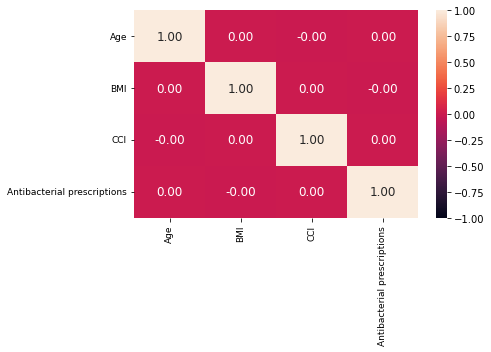

In [46]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(data_urti_combined[['age', 'bmi', 'CCI', 'antibacterial_brit']].corr(), 
            annot=True, fmt=".2f", annot_kws={"size":12},
            vmin=-1.0, vmax=1.0)

ax.set_xticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions'], rotation=90, fontsize=9)
ax.set_yticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions',], rotation=0, fontsize=9)                        
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti_combined/corr_urti_combined.jpg')
plt.show()

## 4- separate data of incident/prevalent and with/without antibiotics and stratified sub-datasets

In [47]:
data_urti_combined = data_urti_combined[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 
                                   'antibacterial_brit', 'urti_combined_ab_date', 'ab_type_cat', 'incdt_urti_combined_date', 'date', 'period',
                                   'event_urti_combined_admitted', 'duration_urti_combined_admitted'
                                    ]]

In [48]:
#switch variable urti_combined_ab_date into a binary variable
data_urti_combined[['ab_binary']] = data_urti_combined[['urti_combined_ab_date']].where(data_urti_combined[['urti_combined_ab_date']].isnull(), 1).fillna(0).astype(int)
#incident and prevalent infection 
data_urti_combined_incdt = data_urti_combined[data_urti_combined['incdt_urti_combined_date'] == 0]
data_urti_combined_prevl = data_urti_combined[data_urti_combined['incdt_urti_combined_date'] == 1]

#no antibiotics and incident hospital admission
data_urti_combined_no_abs_incdt = data_urti_combined_incdt[data_urti_combined_incdt['ab_binary'] == 0]
#with antibiotics and incident hospital admission
data_urti_combined_abs_incdt = data_urti_combined_incdt[data_urti_combined_incdt['ab_binary'] == 1]

#no antibiotics and prevalent hospital admission
data_urti_combined_no_abs_prevl = data_urti_combined_prevl[data_urti_combined_prevl['ab_binary'] == 0]
#with antibiotics and prevalent hospital admission
data_urti_combined_abs_prevl = data_urti_combined_prevl[data_urti_combined_prevl['ab_binary'] == 1]

In [49]:
##subcohorts for stratification by period
#incident and prevalent infection stratified by time period categories
data_urti_combined_incdt_prepandemic = data_urti_combined_incdt[data_urti_combined_incdt['period'] == 'prepandemic']
data_urti_combined_incdt_during_pandemic = data_urti_combined_incdt[(data_urti_combined_incdt['period'] == 'during_pandemic')]
data_urti_combined_incdt_post_2nd_lockdown = data_urti_combined_incdt[data_urti_combined_incdt['period'] == 'post_2nd_lockdown']
data_urti_combined_prevl_prepandemic = data_urti_combined_prevl[data_urti_combined_prevl['period'] == 'prepandemic']
data_urti_combined_prevl_during_pandemic = data_urti_combined_prevl[(data_urti_combined_prevl['period'] == 'during_pandemic')]
data_urti_combined_prevl_post_2nd_lockdown = data_urti_combined_prevl[data_urti_combined_prevl['period'] == 'post_2nd_lockdown']

#no antibiotics and incident hospital admission
data_urti_combined_no_abs_incdt_prepandemic = data_urti_combined_incdt_prepandemic[data_urti_combined_incdt_prepandemic['ab_binary'] == 0]
data_urti_combined_no_abs_incdt_during_pandemic = data_urti_combined_incdt_during_pandemic[data_urti_combined_incdt_during_pandemic['ab_binary'] == 0]
data_urti_combined_no_abs_incdt_post_2nd_lockdown = data_urti_combined_incdt_post_2nd_lockdown[data_urti_combined_incdt_post_2nd_lockdown['ab_binary'] == 0]
data_urti_combined_no_abs_prevl_prepandemic = data_urti_combined_prevl_prepandemic[data_urti_combined_prevl_prepandemic['ab_binary'] == 0]
data_urti_combined_no_abs_prevl_during_pandemic = data_urti_combined_prevl_during_pandemic[data_urti_combined_prevl_during_pandemic['ab_binary'] == 0]
data_urti_combined_no_abs_prevl_post_2nd_lockdown = data_urti_combined_prevl_post_2nd_lockdown[data_urti_combined_prevl_post_2nd_lockdown['ab_binary'] == 0]

In [50]:
#store data for plotting hosp admission counts and percentages
%store data_urti_combined
# save data
data_urti_combined.to_csv('../output/hospitalisation_prediction_urti_combined/data_urti_combined.csv')

Stored 'data_urti_combined' (DataFrame)


## 5- modelling of antibiotics prediction based on risk of hospital admission
### 5-1- incident

<lifelines.CoxPHFitter: fitted with 225008 total observations, 223475 right-censored observations>
             duration col = 'duration_urti_combined_admitted'
                event col = 'event_urti_combined_admitted'
      baseline estimation = breslow
   number of observations = 225008
number of events observed = 1533
   partial log-likelihood = -18870.52
         time fit was run = 2023-06-28 22:05:31 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.06       0.94       0.08            -0.21             0.08                 0.81                 1.09
CCI_cat[T.medium]                0.02       1.02       0.08            -0.14             0.19                 0.87                 1.20
CCI_cat[T.high]                 -0.01       0.99       0.10            -0.20             0.19                 0.82                 1.21
CCI_cat[T.very_high]            -0.07       0.93       0.09            -0.24             0.11                 0.79                 1.11
age_cat[T.25_34]                 0.05       1.05       0.09            -0.14             0.23                 0.87                 1.26
age_cat[T.35_44]                 0.09       1.10       0.09            -0.09             0.28                 0.91                 1.32
age_cat[T.45_54]                 0.02       1.02       0.10            -0.17             0.21                 0.85                 1.23
age_cat[T.55_64]                -0.10       0.91       0.10            -0.29             0.10                 0.75                 1.10
age_cat[T.65_74]                -0.02       0.98       0.10            -0.21             0.17                 0.81                 1.19
age_cat[T.75_more]              -0.04       0.96       0.10            -0.23             0.15                 0.79                 1.16
antibacterial_brit               0.01       1.01       0.02            -0.03             0.04                 0.97                 1.04
bmi_cat[T.obese]                -0.11       0.89       0.09            -0.29             0.07                 0.75                 1.07
bmi_cat[T.overweight]           -0.06       0.94       0.11            -0.28             0.16                 0.75                 1.17
bmi_cat[T.underweight]          -0.06       0.94       0.16            -0.38             0.25                 0.68                 1.29
bmi_cat[T.unknown]              -0.18       0.83       0.10            -0.38             0.01                 0.69                 1.01
ethnicity[T.other]               0.06       1.06       0.13            -0.20             0.31                 0.82                 1.36
ethnicity[T.unknown]             0.01       1.01       0.11            -0.20             0.21                 0.82                 1.24
ethnicity[T.white]              -0.03       0.97       0.10            -0.22             0.16                 0.80                 1.18
flu_vaccine[T.yes]               0.05       1.05       0.08            -0.12             0.21                 0.89                 1.24
imd[T.medium]                   -0.04       0.96       0.08            -0.21             0.12                 0.81                 1.13
imd[T.unaffluent]               -0.06       0.94       0.08            -0.23             0.10                 0.80                 1.11
imd[T.unknown]                   0.10       1.11       0.12            -0.14             0.34                 0.87                 1.41
imd[T.very_affluent]             0.01       1.01       0.08            -0.16             0.17                 0.86                 1.18
imd[T.very_unaffluent]           0.05       1.05       0.08            -0.11             0.21                 0.90                 1.24
region[T.east_midlands]         -0.10       0

12252


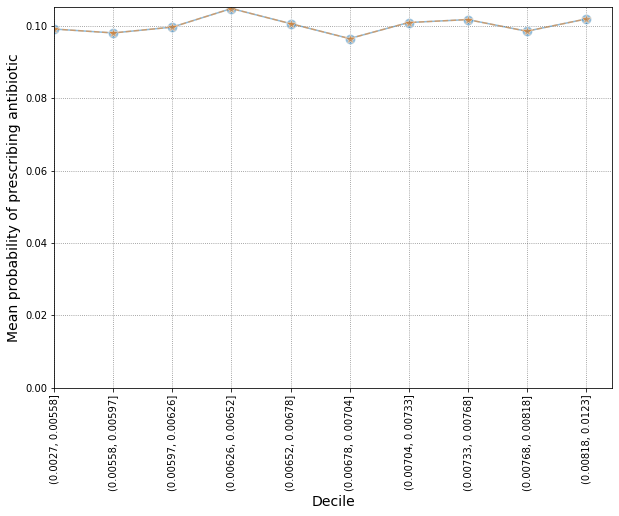


AUROC of LR for deciles with development and validation data: 0.50788 and 0.50410
AUROC of RF for deciles with development and validation data: 0.51394 and 0.50339
LR coefficients:
                                OR  Lower CI  Upper CI
bins_(0.0027, 0.00558]   0.110519  0.105915  0.115322
bins_(0.00558, 0.00597]  0.107490  0.102955  0.112225
bins_(0.00597, 0.00626]  0.110180  0.105560  0.115003
bins_(0.00626, 0.00652]  0.116808  0.112014  0.121806
bins_(0.00652, 0.00678]  0.112714  0.108023  0.117608
bins_(0.00678, 0.00704]  0.105651  0.101130  0.110373
bins_(0.00704, 0.00733]  0.112910  0.108190  0.117836
bins_(0.00733, 0.00768]  0.111797  0.107106  0.116693
bins_(0.00768, 0.00818]  0.108281  0.103683  0.113083
bins_(0.00818, 0.0123]   0.112592  0.107857  0.117534
antibacterial_brit       1.003227  0.994056  1.012482

RF feature importance:
                           rf_coef
antibacterial_brit       0.567629
bins_(0.00626, 0.00652]  0.088096
bins_(0.00678, 0.00704]  0.076294
bins_(0.

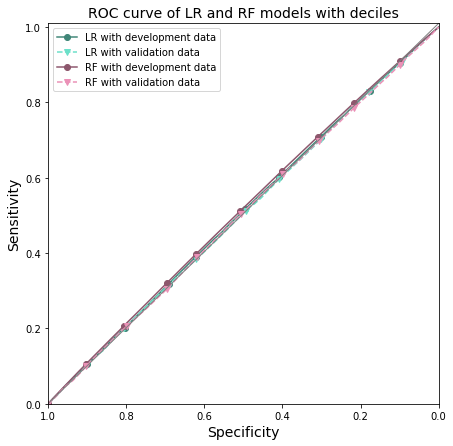

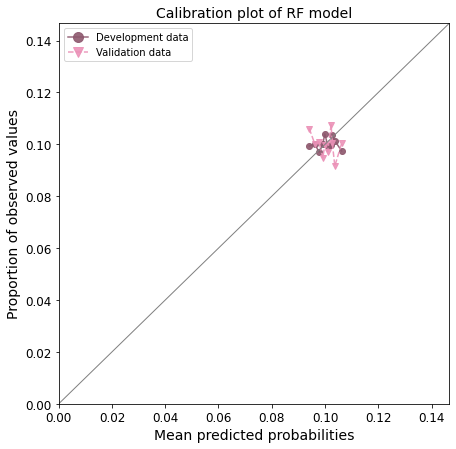

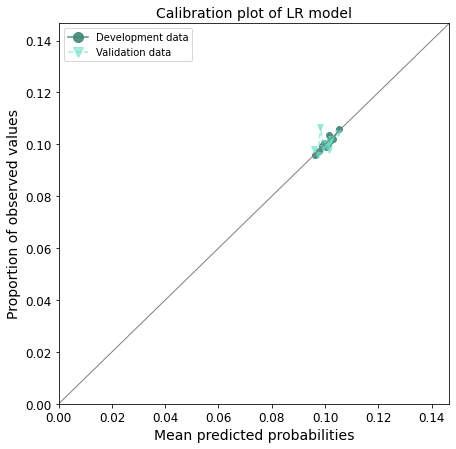


AUROC of LR for risk factors with development and validation data: 0.51199 and 0.49481
AUROC of RF for risk factors with development and validation data: 0.57486 and 0.49642
LR coefficients:
                                    OR  Lower CI  Upper CI
age_cat_15_24                0.878638   0.00000       inf
age_cat_25_34                0.906011   0.00000       inf
age_cat_35_44                0.889557   0.00000       inf
age_cat_45_54                0.889908   0.00000       inf
age_cat_55_64                0.878620   0.00000       inf
age_cat_65_74                0.888728   0.00000       inf
age_cat_75_more              0.867100   0.00000       inf
sex_female                   0.646763       NaN       NaN
sex_male                     0.659715       NaN       NaN
CCI_cat_high                 0.850982       NaN       NaN
CCI_cat_low                  0.837825       NaN       NaN
CCI_cat_medium               0.844670       NaN       NaN
CCI_cat_very_high            0.838498       NaN      

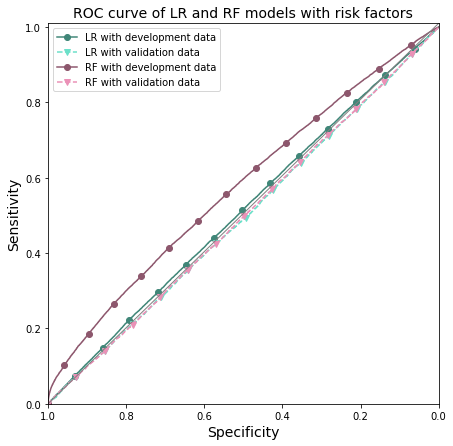

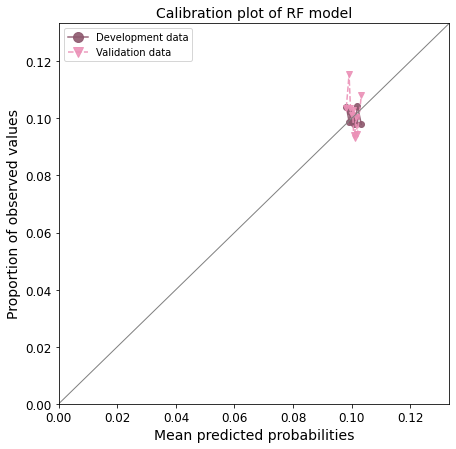

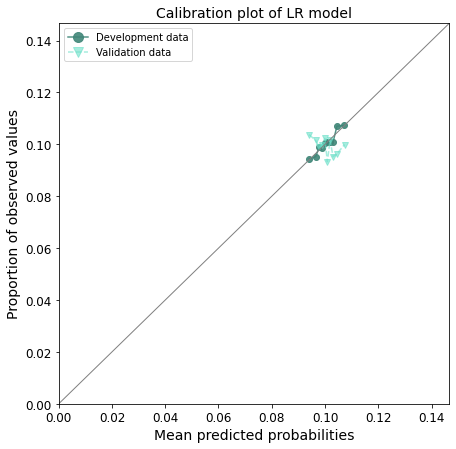

In [51]:
#build cox model for hosp prediction using non ab users' data
prob_pred_urti_combined_no_abs_incdt, prob_pred_urti_combined_no_abs_incdt_bin = cox_build('urti_combined', 'incdt', data_urti_combined_incdt, data_urti_combined_no_abs_incdt)

#build rf and lr models with deciles as predictors
prob_pred_enc_lr_rf_incdt, data_enc_dev_incdt, data_enc_val_incdt, lr_pred_dev_incdt, lr_pred_val_incdt, rf_pred_dev_incdt, rf_pred_val_incdt = lr_rf_build_risk_deciles('urti_combined', 'incdt_deciles', prob_pred_urti_combined_no_abs_incdt)

#make summary table
make_summary_table('urti_combined', 'incdt', prob_pred_enc_lr_rf_incdt)

#calibration plots of rf and lr with deciles
calibration_rf_lr('urti_combined', 'incdt_deciles', data_enc_dev_incdt, data_enc_val_incdt, lr_pred_dev_incdt, lr_pred_val_incdt, rf_pred_dev_incdt, rf_pred_val_incdt)

#build rf and lr models with all risk factors (e.g. age, sex, ethnicity) as predictors
prob_pred_enc_lr_rf_incdt, data_enc_dev_incdt, data_enc_val_incdt, lr_pred_dev_incdt, lr_pred_val_incdt, rf_pred_dev_incdt, rf_pred_val_incdt = lr_rf_build_risk_riskfactors('urti_combined', 'incdt_riskfactors', prob_pred_urti_combined_no_abs_incdt)

#calibration plots of rf and lr with risk factors
calibration_rf_lr('urti_combined', 'incdt_riskfactors', data_enc_dev_incdt, data_enc_val_incdt, lr_pred_dev_incdt, lr_pred_val_incdt, rf_pred_dev_incdt, rf_pred_val_incdt)

#### 5-2- prevalent

<lifelines.CoxPHFitter: fitted with 25036 total observations, 24859 right-censored observations>
             duration col = 'duration_urti_combined_admitted'
                event col = 'event_urti_combined_admitted'
      baseline estimation = breslow
   number of observations = 25036
number of events observed = 177
   partial log-likelihood = -1776.32
         time fit was run = 2023-06-28 22:07:29 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.23       0.79       0.21            -0.65             0.18                 0.52                 1.20
CCI_cat[T.medium]               -0.05       0.96       0.23            -0.49             0.40                 0.61                 1.49
CCI_cat[T.high]                 -0.45       0.64       0.32            -1.07             0.16                 0.34                 1.18
CCI_cat[T.very_high]            -0.34       0.71       0.26            -0.85             0.18                 0.43                 1.19
age_cat[T.25_34]                 0.10       1.10       0.28            -0.45             0.64                 0.64                 1.90
age_cat[T.35_44]                -0.20       0.82       0.30            -0.78             0.39                 0.46                 1.48
age_cat[T.45_54]                 0.02       1.02       0.28            -0.54             0.57                 0.58                 1.77
age_cat[T.55_64]                 0.30       1.35       0.26            -0.21             0.82                 0.81                 2.27
age_cat[T.65_74]                -0.10       0.90       0.29            -0.67             0.47                 0.51                 1.60
age_cat[T.75_more]              -0.03       0.97       0.29            -0.59             0.53                 0.55                 1.69
antibacterial_brit              -0.09       0.91       0.06            -0.20             0.02                 0.82                 1.02
bmi_cat[T.obese]                -0.41       0.66       0.24            -0.89             0.06                 0.41                 1.06
bmi_cat[T.overweight]           -0.18       0.83       0.30            -0.77             0.40                 0.46                 1.50
bmi_cat[T.underweight]          -0.74       0.48       0.55            -1.81             0.33                 0.16                 1.39
bmi_cat[T.unknown]              -0.55       0.57       0.27            -1.09            -0.02                 0.34                 0.98
ethnicity[T.other]               0.32       1.37       0.43            -0.53             1.17                 0.59                 3.22
ethnicity[T.unknown]             0.40       1.49       0.36            -0.32             1.11                 0.73                 3.04
ethnicity[T.white]               0.38       1.46       0.35            -0.30             1.06                 0.74                 2.89
flu_vaccine[T.yes]              -0.08       0.92       0.26            -0.60             0.43                 0.55                 1.54
imd[T.medium]                    0.04       1.04       0.24            -0.43             0.50                 0.65                 1.65
imd[T.unaffluent]               -0.12       0.89       0.25            -0.60             0.37                 0.55                 1.45
imd[T.unknown]                  -0.15       0.86       0.39            -0.92             0.62                 0.40                 1.86
imd[T.very_affluent]            -0.05       0.95       0.24            -0.52             0.42                 0.59                 1.53
imd[T.very_unaffluent]          -0.09       0.92       0.24            -0.57             0.39                 0.57                 1.48
region[T.east_midlands]          0.15       1.16  

12252


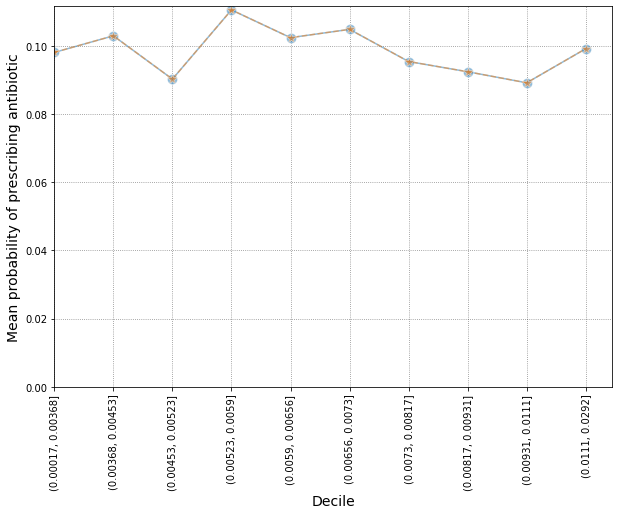


AUROC of LR for deciles with development and validation data: 0.52264 and 0.51289
AUROC of RF for deciles with development and validation data: 0.53953 and 0.50180
LR coefficients:
                                OR  Lower CI  Upper CI
bins_(0.00017, 0.00368]  0.106449  0.092728  0.122199
bins_(0.00368, 0.00453]  0.109344  0.095578  0.125092
bins_(0.00453, 0.00523]  0.096581  0.084051  0.110978
bins_(0.00523, 0.0059]   0.124213  0.109655  0.140704
bins_(0.0059, 0.00656]   0.115756  0.101945  0.131439
bins_(0.00656, 0.0073]   0.115266  0.101550  0.130835
bins_(0.0073, 0.00817]   0.101252  0.088682  0.115603
bins_(0.00817, 0.00931]  0.101051  0.088603  0.115249
bins_(0.00931, 0.0111]   0.096983  0.084922  0.110757
bins_(0.0111, 0.0292]    0.113238  0.100060  0.128152
antibacterial_brit       1.005997  0.977043  1.035809

RF feature importance:
                           rf_coef
antibacterial_brit       0.564231
bins_(0.00523, 0.0059]   0.084987
bins_(0.00931, 0.0111]   0.058809
bins_(0.

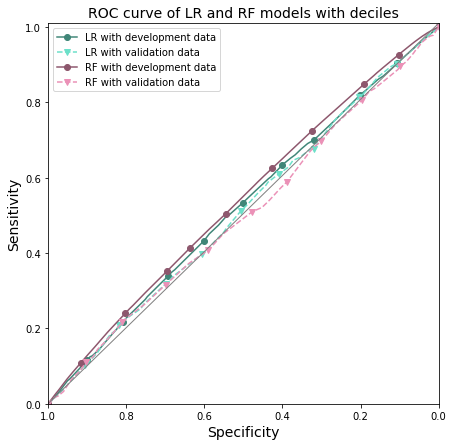

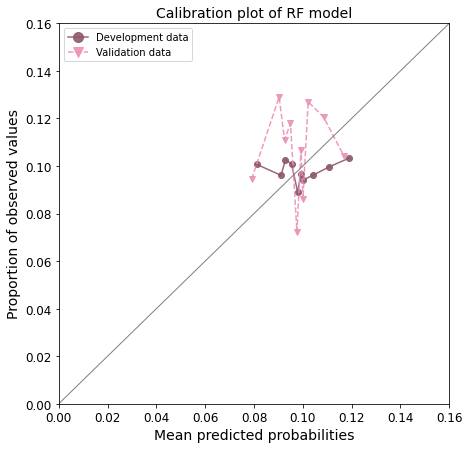

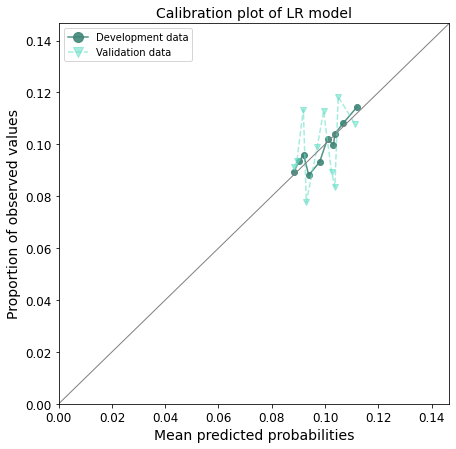


AUROC of LR for risk factors with development and validation data: 0.53550 and 0.51206
AUROC of RF for risk factors with development and validation data: 0.70911 and 0.52023
LR coefficients:
                                    OR  Lower CI  Upper CI
age_cat_15_24                0.850970  0.000000       inf
age_cat_25_34                0.901250  0.000000       inf
age_cat_35_44                0.843456  0.000000       inf
age_cat_45_54                0.818976  0.000000       inf
age_cat_55_64                0.914896  0.000000       inf
age_cat_65_74                0.889969  0.000000       inf
age_cat_75_more              0.983114  0.000000       inf
sex_female                   0.630827  0.000000       inf
sex_male                     0.672254  0.000000       inf
CCI_cat_high                 0.844264  0.000000       inf
CCI_cat_low                  0.822392  0.000000       inf
CCI_cat_medium               0.802750  0.000000       inf
CCI_cat_very_high            0.866856  0.000000      

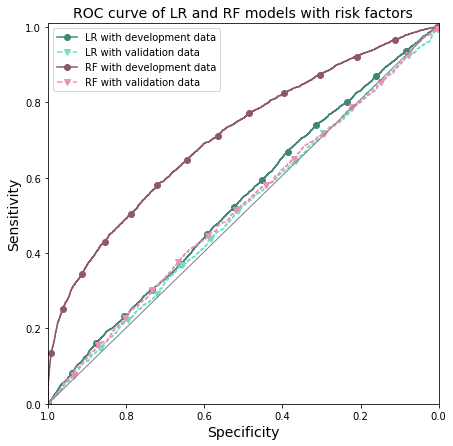

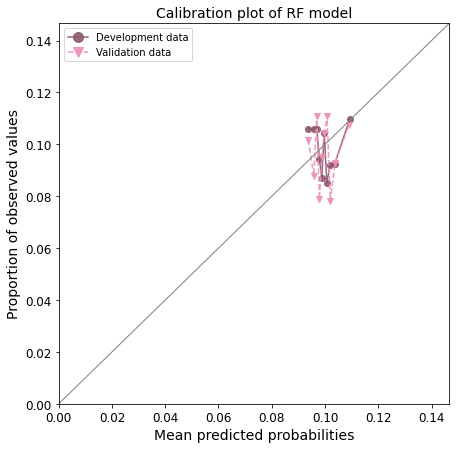

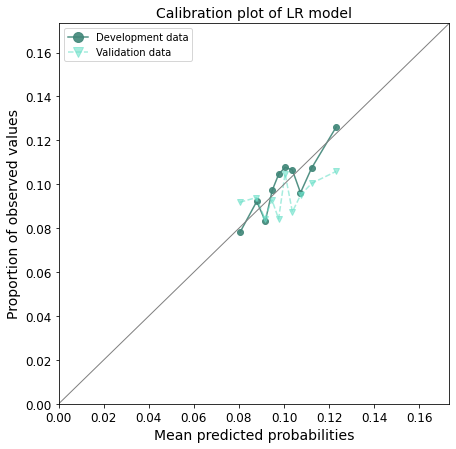

In [52]:
#build cox model for hosp prediction using non ab users' data
prob_pred_urti_combined_no_abs_prevl, prob_pred_urti_combined_no_abs_prevl_bin = cox_build('urti_combined', 'prevl', data_urti_combined_prevl, data_urti_combined_no_abs_prevl)

#build rf and lr models with deciles as predictors
prob_pred_enc_lr_rf_prevl, data_enc_dev_prevl, data_enc_val_prevl, lr_pred_dev_prevl, lr_pred_val_prevl, rf_pred_dev_prevl, rf_pred_val_prevl = lr_rf_build_risk_deciles('urti_combined', 'prevl_deciles', prob_pred_urti_combined_no_abs_prevl)

#make summary table
make_summary_table('urti_combined', 'prevl', prob_pred_enc_lr_rf_prevl)

#calibration plots of rf and lr with deciles
calibration_rf_lr('urti_combined', 'prevl_deciles', data_enc_dev_prevl, data_enc_val_prevl, lr_pred_dev_prevl, lr_pred_val_prevl, rf_pred_dev_prevl, rf_pred_val_prevl)

#build rf and lr models with all risk factors (e.g. age, sex, ethnicity) as predictors
prob_pred_enc_lr_rf_prevl, data_enc_dev_prevl, data_enc_val_prevl, lr_pred_dev_prevl, lr_pred_val_prevl, rf_pred_dev_prevl, rf_pred_val_prevl = lr_rf_build_risk_riskfactors('urti_combined', 'prevl_riskfactors', prob_pred_urti_combined_no_abs_prevl)

#calibration plots of rf and lr with risk factors
calibration_rf_lr('urti_combined', 'prevl_riskfactors', data_enc_dev_prevl, data_enc_val_prevl, lr_pred_dev_prevl, lr_pred_val_prevl, rf_pred_dev_prevl, rf_pred_val_prevl)

#### 5-3- stratification by time period
#### 5-3-1- incident

<lifelines.CoxPHFitter: fitted with 62033 total observations, 61651 right-censored observations>
             duration col = 'duration_urti_combined_admitted'
                event col = 'event_urti_combined_admitted'
      baseline estimation = breslow
   number of observations = 62033
number of events observed = 382
   partial log-likelihood = -4196.10
         time fit was run = 2023-06-28 22:07:45 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.08       0.92       0.15            -0.38             0.22                 0.68                 1.24
CCI_cat[T.medium]                0.05       1.05       0.17            -0.28             0.37                 0.76                 1.45
CCI_cat[T.high]                  0.07       1.08       0.20            -0.31             0.46                 0.73                 1.58
CCI_cat[T.very_high]            -0.04       0.96       0.18            -0.39             0.31                 0.68                 1.36
age_cat[T.25_34]                -0.14       0.87       0.20            -0.53             0.24                 0.59                 1.27
age_cat[T.35_44]                 0.07       1.07       0.19            -0.30             0.43                 0.74                 1.54
age_cat[T.45_54]                -0.28       0.75       0.20            -0.68             0.11                 0.51                 1.12
age_cat[T.55_64]                 0.03       1.03       0.19            -0.34             0.39                 0.71                 1.48
age_cat[T.65_74]                 0.08       1.08       0.18            -0.28             0.44                 0.75                 1.55
age_cat[T.75_more]              -0.06       0.95       0.19            -0.43             0.32                 0.65                 1.38
antibacterial_brit              -0.04       0.96       0.04            -0.11             0.03                 0.89                 1.03
bmi_cat[T.obese]                 0.08       1.08       0.19            -0.30             0.45                 0.74                 1.57
bmi_cat[T.overweight]           -0.14       0.87       0.24            -0.61             0.34                 0.54                 1.41
bmi_cat[T.underweight]           0.05       1.05       0.33            -0.60             0.70                 0.55                 2.01
bmi_cat[T.unknown]              -0.03       0.97       0.21            -0.43             0.38                 0.65                 1.46
ethnicity[T.other]               0.04       1.04       0.25            -0.46             0.53                 0.63                 1.70
ethnicity[T.unknown]             0.09       1.10       0.20            -0.31             0.49                 0.74                 1.63
ethnicity[T.white]              -0.16       0.85       0.19            -0.54             0.22                 0.58                 1.24
flu_vaccine[T.yes]               0.04       1.04       0.17            -0.29             0.37                 0.75                 1.45
imd[T.medium]                   -0.12       0.89       0.16            -0.43             0.19                 0.65                 1.21
imd[T.unaffluent]               -0.12       0.89       0.16            -0.43             0.20                 0.65                 1.22
imd[T.unknown]                  -0.24       0.79       0.26            -0.75             0.27                 0.47                 1.31
imd[T.very_affluent]            -0.26       0.77       0.17            -0.59             0.07                 0.56                 1.07
imd[T.very_unaffluent]          -0.17       0.84       0.16            -0.49             0.14                 0.61                 1.15
region[T.east_midlands]          0.08       1.08  

12229


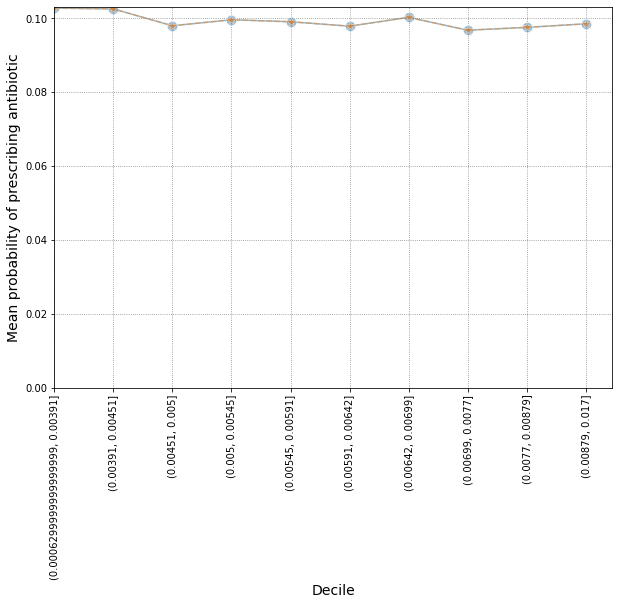


AUROC of LR for deciles with development and validation data: 0.51142 and 0.49336
AUROC of RF for deciles with development and validation data: 0.52439 and 0.49434
LR coefficients:
                                              OR  Lower CI  Upper CI
bins_(0.0006299999999999999, 0.00391]  0.111525  0.102579  0.121252
bins_(0.00391, 0.00451]                0.114788  0.105721  0.124633
bins_(0.00451, 0.005]                  0.105822  0.097350  0.115032
bins_(0.005, 0.00545]                  0.108918  0.100303  0.118272
bins_(0.00545, 0.00591]                0.108582  0.100019  0.117878
bins_(0.00591, 0.00642]                0.106313  0.097879  0.115474
bins_(0.00642, 0.00699]                0.110106  0.101543  0.119391
bins_(0.00699, 0.0077]                 0.105763  0.097440  0.114798
bins_(0.0077, 0.00879]                 0.103118  0.094931  0.112011
bins_(0.00879, 0.017]                  0.104203  0.096024  0.113079
antibacterial_brit                     1.014513  0.996667  1.032677



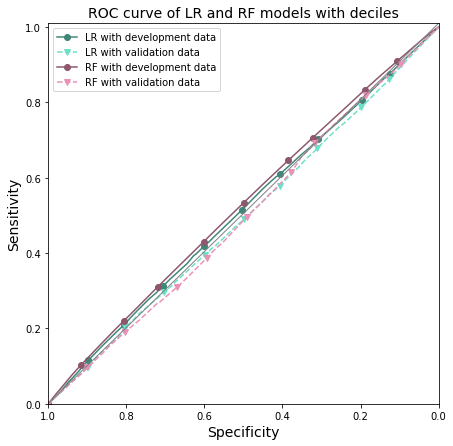

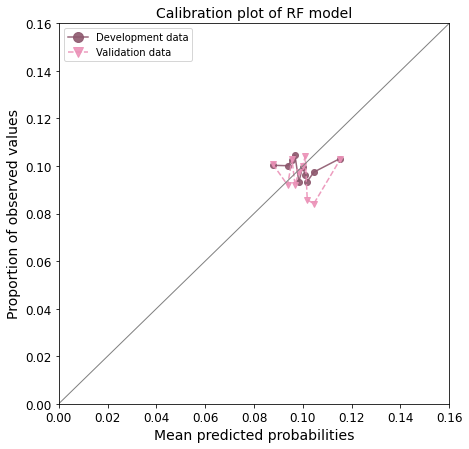

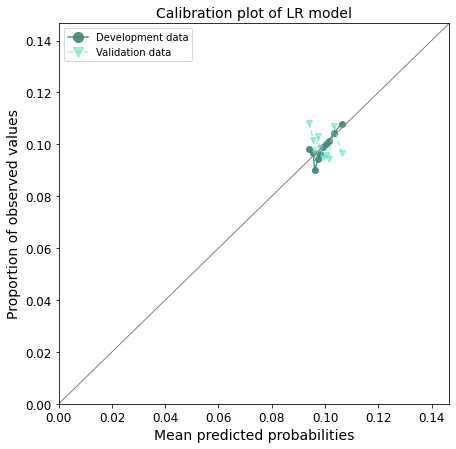

In [53]:
#build cox model for hosp prediction using non ab users' data
prob_pred_urti_combined_no_abs_incdt_prepandemic, prob_pred_urti_combined_no_abs_incdt_prepandemic_bin = cox_build('urti_combined', 'incdt_prepandemic', data_urti_combined_incdt_prepandemic, data_urti_combined_no_abs_incdt_prepandemic)

#build rf and lr models
prob_pred_enc_lr_rf_incdt_prepandemic, data_enc_dev_incdt_prepandemic, data_enc_val_incdt_prepandemic, lr_pred_dev_incdt_prepandemic, lr_pred_val_incdt_prepandemic, rf_pred_dev_incdt_prepandemic, rf_pred_val_incdt_prepandemic = lr_rf_build_risk_deciles('urti_combined', 'incdt_prepandemic', prob_pred_urti_combined_no_abs_incdt_prepandemic)

#calibration plots of rf and lr
calibration_rf_lr('urti_combined', 'incdt_prepandemic', data_enc_dev_incdt_prepandemic, data_enc_val_incdt_prepandemic, lr_pred_dev_incdt_prepandemic, lr_pred_val_incdt_prepandemic, rf_pred_dev_incdt_prepandemic, rf_pred_val_incdt_prepandemic)

<lifelines.CoxPHFitter: fitted with 71271 total observations, 70802 right-censored observations>
             duration col = 'duration_urti_combined_admitted'
                event col = 'event_urti_combined_admitted'
      baseline estimation = breslow
   number of observations = 71271
number of events observed = 469
   partial log-likelihood = -5227.79
         time fit was run = 2023-06-28 22:07:59 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.06       0.94       0.14            -0.33             0.21                 0.72                 1.24
CCI_cat[T.medium]               -0.05       0.95       0.15            -0.35             0.25                 0.71                 1.29
CCI_cat[T.high]                  0.21       1.24       0.17            -0.12             0.55                 0.88                 1.73
CCI_cat[T.very_high]            -0.01       0.99       0.16            -0.32             0.30                 0.73                 1.36
age_cat[T.25_34]                 0.03       1.03       0.17            -0.30             0.36                 0.74                 1.43
age_cat[T.35_44]                -0.04       0.96       0.17            -0.37             0.30                 0.69                 1.34
age_cat[T.45_54]                -0.07       0.93       0.17            -0.41             0.27                 0.67                 1.31
age_cat[T.55_64]                -0.10       0.90       0.17            -0.44             0.24                 0.64                 1.27
age_cat[T.65_74]                 0.00       1.00       0.17            -0.33             0.33                 0.72                 1.39
age_cat[T.75_more]              -0.16       0.86       0.18            -0.50             0.19                 0.60                 1.21
antibacterial_brit               0.02       1.02       0.03            -0.04             0.09                 0.96                 1.09
bmi_cat[T.obese]                -0.10       0.91       0.17            -0.42             0.23                 0.66                 1.26
bmi_cat[T.overweight]           -0.20       0.82       0.21            -0.62             0.21                 0.54                 1.24
bmi_cat[T.underweight]          -0.13       0.88       0.30            -0.72             0.46                 0.49                 1.58
bmi_cat[T.unknown]              -0.12       0.88       0.18            -0.48             0.23                 0.62                 1.26
ethnicity[T.other]              -0.05       0.95       0.25            -0.54             0.44                 0.58                 1.55
ethnicity[T.unknown]            -0.02       0.98       0.20            -0.41             0.37                 0.66                 1.44
ethnicity[T.white]               0.13       1.14       0.18            -0.23             0.49                 0.80                 1.63
flu_vaccine[T.yes]               0.10       1.11       0.15            -0.19             0.39                 0.83                 1.48
imd[T.medium]                    0.21       1.23       0.16            -0.10             0.52                 0.90                 1.68
imd[T.unaffluent]                0.16       1.18       0.16            -0.15             0.48                 0.86                 1.61
imd[T.unknown]                   0.19       1.21       0.24            -0.28             0.66                 0.76                 1.94
imd[T.very_affluent]             0.32       1.38       0.15             0.02             0.63                 1.02                 1.87
imd[T.very_unaffluent]           0.35       1.42       0.15             0.05             0.65                 1.05                 1.92
region[T.east_midlands]         -0.20       0.82  

12250


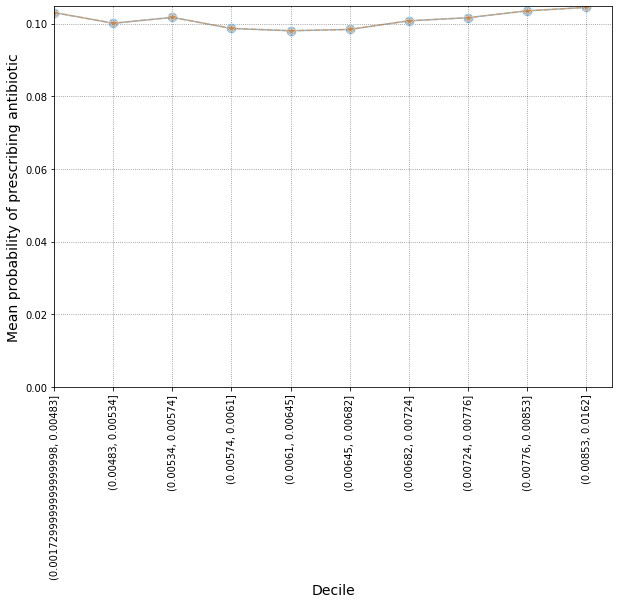


AUROC of LR for deciles with development and validation data: 0.50837 and 0.50056
AUROC of RF for deciles with development and validation data: 0.52112 and 0.49815
LR coefficients:
                                              OR  Lower CI  Upper CI
bins_(0.0017299999999999998, 0.00483]  0.116899  0.108594  0.125841
bins_(0.00483, 0.00534]                0.112382  0.104205  0.121199
bins_(0.00534, 0.00574]                0.114686  0.106385  0.123635
bins_(0.00574, 0.0061]                 0.112487  0.104313  0.121302
bins_(0.0061, 0.00645]                 0.111611  0.103449  0.120417
bins_(0.00645, 0.00682]                0.110045  0.101872  0.118874
bins_(0.00682, 0.00724]                0.113993  0.105619  0.123031
bins_(0.00724, 0.00776]                0.116002  0.107503  0.125172
bins_(0.00776, 0.00853]                0.117946  0.109292  0.127285
bins_(0.00853, 0.0162]                 0.117878  0.109144  0.127310
antibacterial_brit                     0.985199  0.969049  1.001618



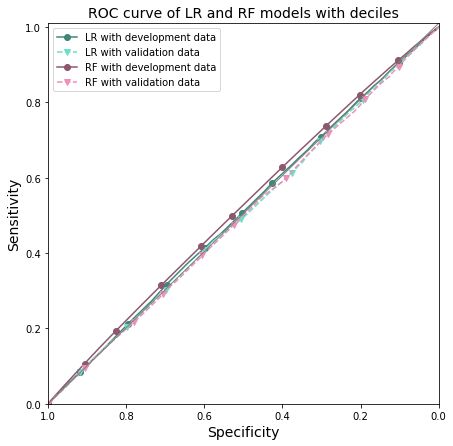

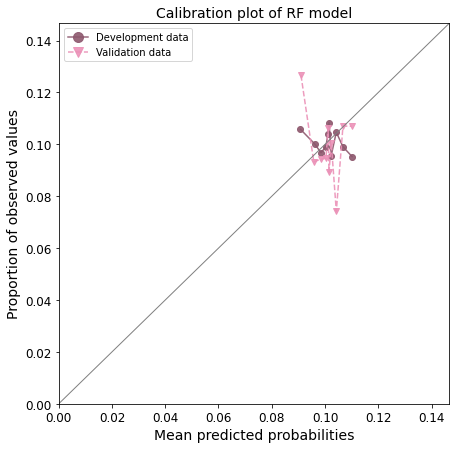

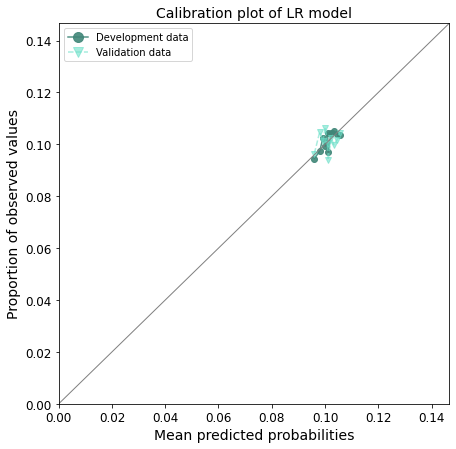

In [54]:
#build cox model for hosp prediction using non ab users' data
prob_pred_urti_combined_no_abs_incdt_during_pandemic, prob_pred_urti_combined_no_abs_incdt_during_pandemic_bin = cox_build('urti_combined', 'incdt_during_pandemic', data_urti_combined_incdt_during_pandemic, data_urti_combined_no_abs_incdt_during_pandemic)

#build rf and lr models
prob_pred_enc_lr_rf_incdt_during_pandemic, data_enc_dev_incdt_during_pandemic, data_enc_val_incdt_during_pandemic, lr_pred_dev_incdt_during_pandemic, lr_pred_val_incdt_during_pandemic, rf_pred_dev_incdt_during_pandemic, rf_pred_val_incdt_during_pandemic = lr_rf_build_risk_deciles('urti_combined', 'incdt_during_pandemic', prob_pred_urti_combined_no_abs_incdt_during_pandemic)

#calibration plots of rf and lr
calibration_rf_lr('urti_combined', 'incdt_during_pandemic', data_enc_dev_incdt_during_pandemic, data_enc_val_incdt_during_pandemic, lr_pred_dev_incdt_during_pandemic, lr_pred_val_incdt_during_pandemic, rf_pred_dev_incdt_during_pandemic, rf_pred_val_incdt_during_pandemic)

<lifelines.CoxPHFitter: fitted with 91704 total observations, 91005 right-censored observations>
             duration col = 'duration_urti_combined_admitted'
                event col = 'event_urti_combined_admitted'
      baseline estimation = breslow
   number of observations = 91704
number of events observed = 699
   partial log-likelihood = -7967.08
         time fit was run = 2023-06-28 22:08:16 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.08       0.92       0.11            -0.30             0.13                 0.74                 1.14
CCI_cat[T.medium]               -0.07       0.93       0.12            -0.32             0.17                 0.73                 1.18
CCI_cat[T.high]                  0.00       1.00       0.14            -0.28             0.28                 0.75                 1.33
CCI_cat[T.very_high]            -0.10       0.90       0.13            -0.36             0.15                 0.70                 1.16
age_cat[T.25_34]                 0.09       1.10       0.15            -0.20             0.38                 0.82                 1.46
age_cat[T.35_44]                 0.33       1.39       0.14             0.06             0.60                 1.06                 1.83
age_cat[T.45_54]                 0.13       1.14       0.15            -0.16             0.41                 0.85                 1.51
age_cat[T.55_64]                 0.02       1.02       0.15            -0.27             0.32                 0.76                 1.37
age_cat[T.65_74]                 0.19       1.21       0.14            -0.10             0.47                 0.91                 1.60
age_cat[T.75_more]               0.05       1.05       0.15            -0.24             0.34                 0.78                 1.40
antibacterial_brit               0.01       1.01       0.03            -0.04             0.06                 0.96                 1.07
bmi_cat[T.obese]                 0.02       1.02       0.14            -0.27             0.30                 0.77                 1.35
bmi_cat[T.overweight]            0.15       1.16       0.17            -0.19             0.48                 0.83                 1.62
bmi_cat[T.underweight]          -0.10       0.90       0.26            -0.60             0.40                 0.55                 1.49
bmi_cat[T.unknown]              -0.07       0.93       0.15            -0.38             0.23                 0.69                 1.26
ethnicity[T.other]               0.17       1.19       0.19            -0.20             0.54                 0.82                 1.72
ethnicity[T.unknown]             0.04       1.04       0.16            -0.27             0.35                 0.77                 1.42
ethnicity[T.white]              -0.04       0.96       0.15            -0.32             0.25                 0.72                 1.29
flu_vaccine[T.yes]               0.15       1.16       0.12            -0.09             0.38                 0.92                 1.46
imd[T.medium]                   -0.01       0.99       0.13            -0.26             0.24                 0.77                 1.27
imd[T.unaffluent]                0.08       1.08       0.13            -0.17             0.32                 0.84                 1.38
imd[T.unknown]                   0.25       1.29       0.18            -0.10             0.60                 0.91                 1.83
imd[T.very_affluent]             0.13       1.14       0.12            -0.11             0.37                 0.90                 1.45
imd[T.very_unaffluent]           0.11       1.11       0.12            -0.14             0.35                 0.87                 1.42
region[T.east_midlands]         -0.06       0.95  

12237


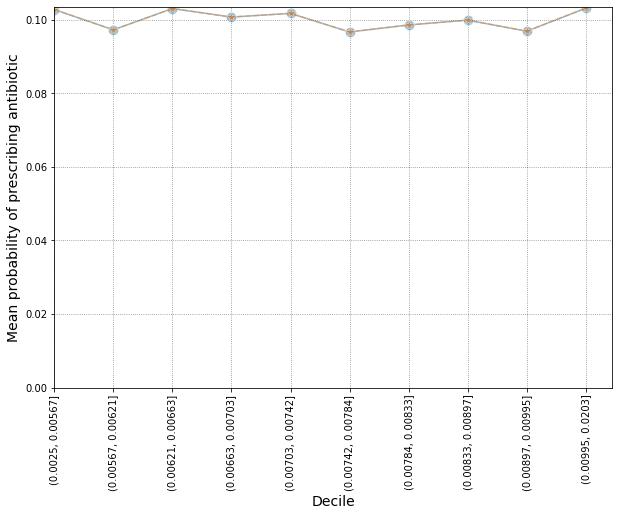


AUROC of LR for deciles with development and validation data: 0.51152 and 0.49491
AUROC of RF for deciles with development and validation data: 0.52037 and 0.50162
LR coefficients:
                                OR  Lower CI  Upper CI
bins_(0.0025, 0.00567]   0.111248  0.104150  0.118830
bins_(0.00567, 0.00621]  0.107032  0.100053  0.114497
bins_(0.00621, 0.00663]  0.117788  0.110369  0.125706
bins_(0.00663, 0.00703]  0.110093  0.102966  0.117714
bins_(0.00703, 0.00742]  0.113149  0.105891  0.120905
bins_(0.00742, 0.00784]  0.109582  0.102470  0.117188
bins_(0.00784, 0.00833]  0.107329  0.100319  0.114829
bins_(0.00833, 0.00897]  0.109053  0.101935  0.116668
bins_(0.00897, 0.00995]  0.104490  0.097545  0.111931
bins_(0.00995, 0.0203]   0.117120  0.109604  0.125152
antibacterial_brit       1.014763  1.000366  1.029367

RF feature importance:
                           rf_coef
antibacterial_brit       0.577966
bins_(0.00995, 0.0203]   0.064962
bins_(0.00621, 0.00663]  0.063682
bins_(0.

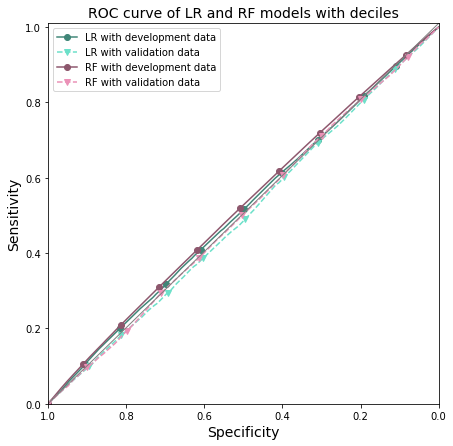

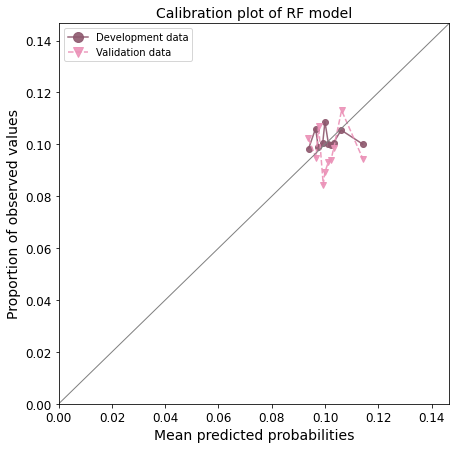

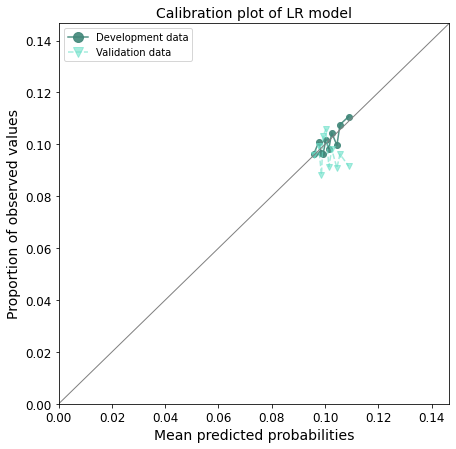

In [55]:
#build cox model for hosp prediction using non ab users' data
prob_pred_urti_combined_no_abs_incdt_post_2nd_lockdown, prob_pred_urti_combined_no_abs_incdt_post_2nd_lockdown_bin = cox_build('urti_combined', 'incdt_post_2nd_lockdown', data_urti_combined_incdt_post_2nd_lockdown, data_urti_combined_no_abs_incdt_post_2nd_lockdown)

#build rf and lr models
prob_pred_enc_lr_rf_incdt_post_2nd_lockdown, data_enc_dev_incdt_post_2nd_lockdown, data_enc_val_incdt_post_2nd_lockdown, lr_pred_dev_incdt_post_2nd_lockdown, lr_pred_val_incdt_post_2nd_lockdown, rf_pred_dev_incdt_post_2nd_lockdown, rf_pred_val_incdt_post_2nd_lockdown = lr_rf_build_risk_deciles('urti_combined', 'incdt_post_2nd_lockdown', prob_pred_urti_combined_no_abs_incdt_post_2nd_lockdown)

#calibration plots of rf and lr
calibration_rf_lr('urti_combined', 'incdt_post_2nd_lockdown', data_enc_dev_incdt_post_2nd_lockdown, data_enc_val_incdt_post_2nd_lockdown, lr_pred_dev_incdt_post_2nd_lockdown, lr_pred_val_incdt_post_2nd_lockdown, rf_pred_dev_incdt_post_2nd_lockdown, rf_pred_val_incdt_post_2nd_lockdown)

#### 5-3-2- prevalent

<lifelines.CoxPHFitter: fitted with 6904 total observations, 6863 right-censored observations>
             duration col = 'duration_urti_combined_admitted'
                event col = 'event_urti_combined_admitted'
      baseline estimation = breslow
   number of observations = 6904
number of events observed = 41
   partial log-likelihood = -348.21
         time fit was run = 2023-06-28 22:08:36 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.38       0.69       0.44            -1.23             0.48                 0.29                 1.61
CCI_cat[T.medium]                0.18       1.20       0.44            -0.67             1.04                 0.51                 2.83
CCI_cat[T.high]                 -1.07       0.34       0.78            -2.61             0.46                 0.07                 1.59
CCI_cat[T.very_high]            -0.79       0.45       0.60            -1.97             0.39                 0.14                 1.48
age_cat[T.25_34]                -0.28       0.75       0.59            -1.44             0.87                 0.24                 2.38
age_cat[T.35_44]                -0.16       0.86       0.56            -1.25             0.94                 0.29                 2.56
age_cat[T.45_54]                -0.17       0.85       0.56            -1.26             0.93                 0.28                 2.52
age_cat[T.55_64]                -0.19       0.83       0.56            -1.29             0.90                 0.28                 2.47
age_cat[T.65_74]                -0.18       0.84       0.56            -1.27             0.92                 0.28                 2.51
age_cat[T.75_more]              -0.34       0.71       0.59            -1.49             0.81                 0.23                 2.26
antibacterial_brit              -0.04       0.96       0.11            -0.26             0.18                 0.77                 1.19
bmi_cat[T.obese]                -0.88       0.42       0.45            -1.76            -0.00                 0.17                 1.00
bmi_cat[T.overweight]           -0.38       0.69       0.54            -1.43             0.68                 0.24                 1.97
bmi_cat[T.underweight]          -0.23       0.79       0.81            -1.81             1.35                 0.16                 3.85
bmi_cat[T.unknown]              -1.10       0.33       0.54            -2.15            -0.04                 0.12                 0.96
ethnicity[T.other]               0.65       1.92       1.23            -1.75             3.06                 0.17                21.35
ethnicity[T.unknown]             1.24       3.46       1.05            -0.81             3.29                 0.45                26.92
ethnicity[T.white]               1.20       3.33       1.02            -0.80             3.20                 0.45                24.59
flu_vaccine[T.yes]              -0.70       0.49       0.73            -2.13             0.72                 0.12                 2.05
imd[T.medium]                    0.12       1.12       0.52            -0.90             1.14                 0.41                 3.11
imd[T.unaffluent]                0.48       1.61       0.49            -0.48             1.43                 0.62                 4.17
imd[T.unknown]                 -16.71       0.00    3157.70         -6205.69          6172.27                 0.00                  inf
imd[T.very_affluent]             0.11       1.12       0.52            -0.91             1.13                 0.40                 3.10
imd[T.very_unaffluent]          -0.02       0.98       0.54            -1.07             1.03                 0.34                 2.80
region[T.east_midlands]          0.49       1.63       

12251


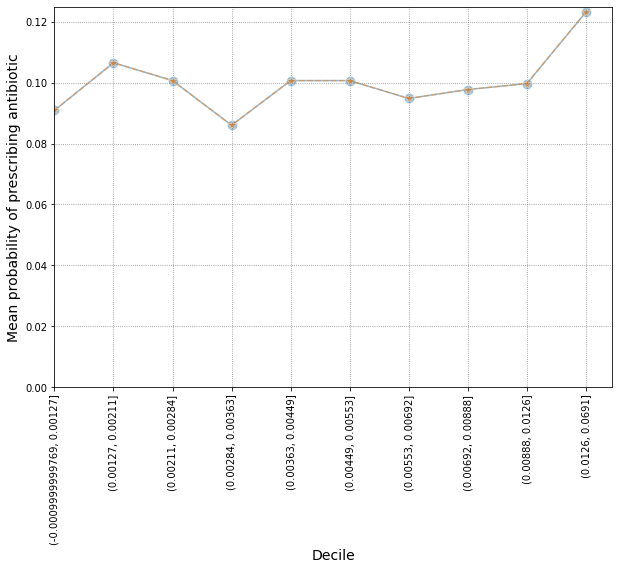


AUROC of LR for deciles with development and validation data: 0.52924 and 0.50581
AUROC of RF for deciles with development and validation data: 0.55516 and 0.47656
LR coefficients:
                                         OR  Lower CI  Upper CI
bins_(-0.0009999999769, 0.00127]  0.109455  0.085108  0.140767
bins_(0.00127, 0.00211]           0.127588  0.100086  0.162648
bins_(0.00211, 0.00284]           0.123809  0.097789  0.156752
bins_(0.00284, 0.00363]           0.100371  0.077809  0.129475
bins_(0.00363, 0.00449]           0.103786  0.080114  0.134451
bins_(0.00449, 0.00553]           0.126994  0.100283  0.160820
bins_(0.00553, 0.00692]           0.112715  0.088278  0.143916
bins_(0.00692, 0.00888]           0.120414  0.094883  0.152815
bins_(0.00888, 0.0126]            0.115309  0.090437  0.147022
bins_(0.0126, 0.0691]             0.137844  0.110448  0.172037
antibacterial_brit                0.969534  0.919387  1.022415

RF feature importance:
                                    r

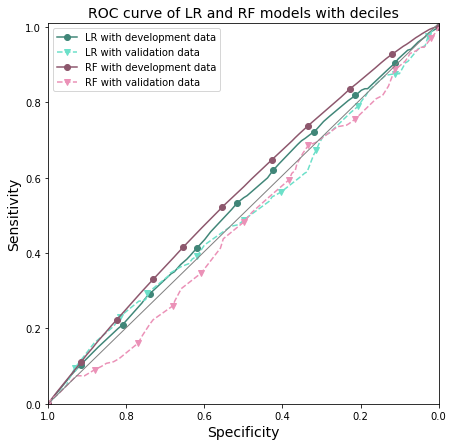

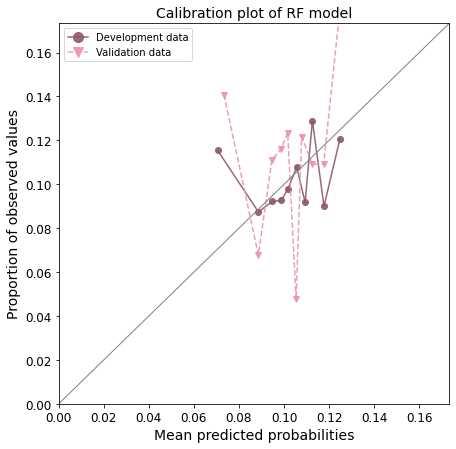

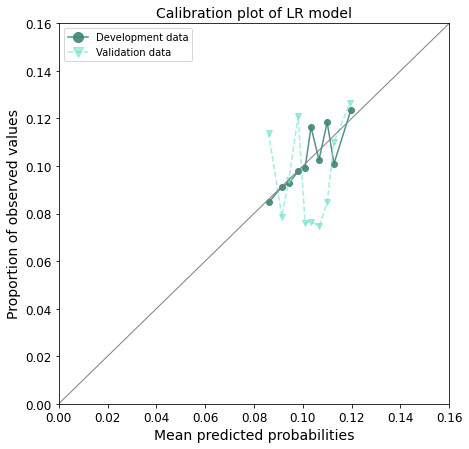

In [56]:
#build cox model for hosp prediction using non ab users' data
prob_pred_urti_combined_no_abs_prevl_prepandemic, prob_pred_urti_combined_no_abs_prevl_prepandemic_bin = cox_build('urti_combined', 'prevl_prepandemic', data_urti_combined_prevl_prepandemic, data_urti_combined_no_abs_prevl_prepandemic)

#build rf and lr models
prob_pred_enc_lr_rf_prevl_prepandemic, data_enc_dev_prevl_prepandemic, data_enc_val_prevl_prepandemic, lr_pred_dev_prevl_prepandemic, lr_pred_val_prevl_prepandemic, rf_pred_dev_prevl_prepandemic, rf_pred_val_prevl_prepandemic = lr_rf_build_risk_deciles('urti_combined', 'prevl_prepandemic', prob_pred_urti_combined_no_abs_prevl_prepandemic)

#calibration plots of rf and lr
calibration_rf_lr('urti_combined', 'prevl_prepandemic', data_enc_dev_prevl_prepandemic, data_enc_val_prevl_prepandemic, lr_pred_dev_prevl_prepandemic, lr_pred_val_prevl_prepandemic, rf_pred_dev_prevl_prepandemic, rf_pred_val_prevl_prepandemic)

<lifelines.CoxPHFitter: fitted with 8087 total observations, 8024 right-censored observations>
             duration col = 'duration_urti_combined_admitted'
                event col = 'event_urti_combined_admitted'
      baseline estimation = breslow
   number of observations = 8087
number of events observed = 63
   partial log-likelihood = -548.91
         time fit was run = 2023-06-28 22:08:42 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.18       1.19       0.38            -0.56             0.92                 0.57                 2.50
CCI_cat[T.medium]                0.02       1.02       0.42            -0.80             0.85                 0.45                 2.34
CCI_cat[T.high]                 -0.38       0.68       0.59            -1.54             0.78                 0.21                 2.18
CCI_cat[T.very_high]             0.20       1.23       0.43            -0.64             1.05                 0.53                 2.85
age_cat[T.25_34]                -0.11       0.90       0.52            -1.13             0.91                 0.32                 2.48
age_cat[T.35_44]                -0.16       0.85       0.52            -1.18             0.85                 0.31                 2.35
age_cat[T.45_54]                 0.38       1.46       0.45            -0.50             1.26                 0.60                 3.54
age_cat[T.55_64]                 0.39       1.48       0.46            -0.50             1.29                 0.60                 3.64
age_cat[T.65_74]                -0.24       0.79       0.54            -1.30             0.82                 0.27                 2.27
age_cat[T.75_more]               0.24       1.27       0.48            -0.69             1.17                 0.50                 3.22
antibacterial_brit              -0.02       0.98       0.09            -0.20             0.15                 0.82                 1.17
bmi_cat[T.obese]                -0.26       0.77       0.42            -1.08             0.56                 0.34                 1.75
bmi_cat[T.overweight]           -0.24       0.78       0.54            -1.30             0.81                 0.27                 2.24
bmi_cat[T.underweight]          -0.88       0.42       1.07            -2.98             1.22                 0.05                 3.39
bmi_cat[T.unknown]              -0.41       0.66       0.46            -1.31             0.49                 0.27                 1.63
ethnicity[T.other]              -0.70       0.49       0.87            -2.41             1.00                 0.09                 2.71
ethnicity[T.unknown]             0.47       1.60       0.55            -0.60             1.55                 0.55                 4.69
ethnicity[T.white]               0.12       1.13       0.53            -0.91             1.16                 0.40                 3.19
flu_vaccine[T.yes]               0.16       1.17       0.40            -0.63             0.95                 0.53                 2.59
imd[T.medium]                   -0.13       0.88       0.39            -0.88             0.63                 0.41                 1.88
imd[T.unaffluent]               -0.16       0.86       0.39            -0.93             0.62                 0.40                 1.86
imd[T.unknown]                  -0.20       0.82       0.64            -1.45             1.05                 0.23                 2.85
imd[T.very_affluent]            -0.49       0.61       0.43            -1.33             0.34                 0.26                 1.41
imd[T.very_unaffluent]          -0.20       0.82       0.39            -0.98             0.57                 0.38                 1.77
region[T.east_midlands]         -0.08       0.92       

12247


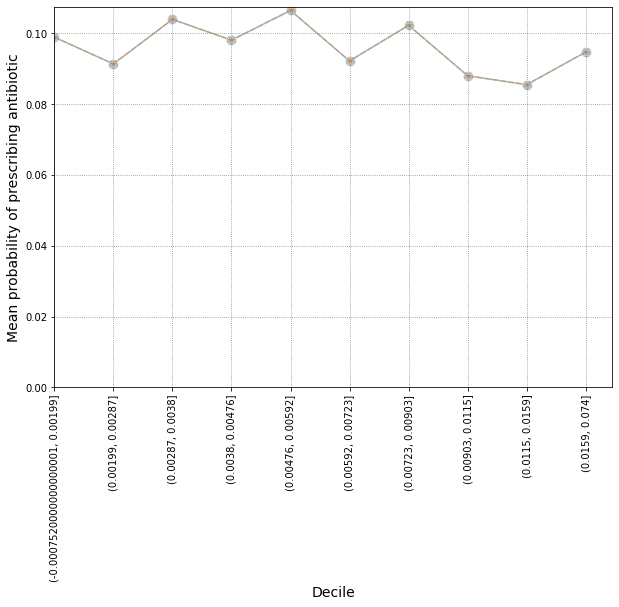


AUROC of LR for deciles with development and validation data: 0.52669 and 0.50222
AUROC of RF for deciles with development and validation data: 0.56195 and 0.46122
LR coefficients:
                                               OR  Lower CI  Upper CI
bins_(-0.0007520000000000001, 0.00199]  0.094134  0.074110  0.119567
bins_(0.00199, 0.00287]                 0.098302  0.077892  0.124060
bins_(0.00287, 0.0038]                  0.105747  0.084199  0.132810
bins_(0.0038, 0.00476]                  0.103829  0.082569  0.130563
bins_(0.00476, 0.00592]                 0.107447  0.085773  0.134597
bins_(0.00592, 0.00723]                 0.097052  0.076853  0.122561
bins_(0.00723, 0.00903]                 0.105622  0.084036  0.132754
bins_(0.00903, 0.0115]                  0.087407  0.068445  0.111621
bins_(0.0115, 0.0159]                   0.091037  0.071567  0.115805
bins_(0.0159, 0.074]                    0.098814  0.078534  0.124332
antibacterial_brit                      1.045048  0.994924

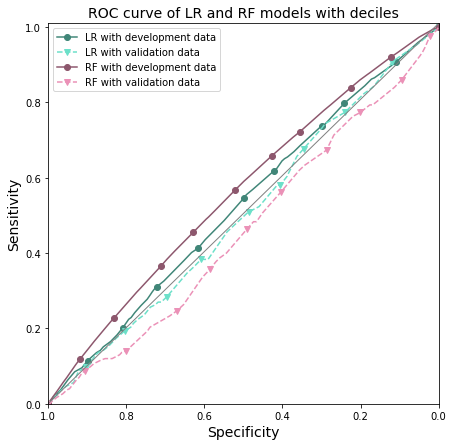

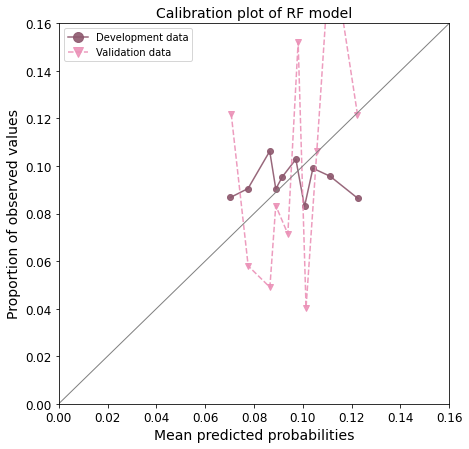

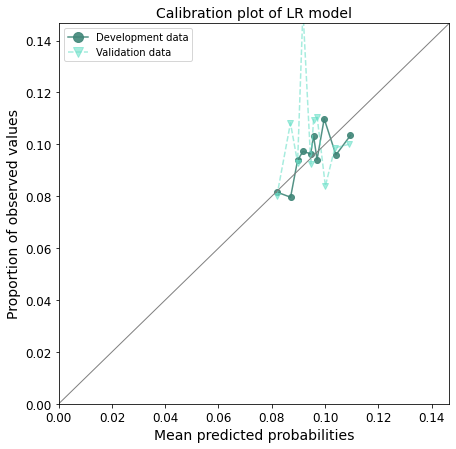

In [57]:
#build cox model for hosp prediction using non ab users' data
prob_pred_urti_combined_no_abs_prevl_during_pandemic, prob_pred_urti_combined_no_abs_prevl_during_pandemic_bin = cox_build('urti_combined', 'prevl_during_pandemic', data_urti_combined_prevl_during_pandemic, data_urti_combined_no_abs_prevl_during_pandemic)

#build rf and lr models
prob_pred_enc_lr_rf_prevl_during_pandemic, data_enc_dev_prevl_during_pandemic, data_enc_val_prevl_during_pandemic, lr_pred_dev_prevl_during_pandemic, lr_pred_val_prevl_during_pandemic, rf_pred_dev_prevl_during_pandemic, rf_pred_val_prevl_during_pandemic = lr_rf_build_risk_deciles('urti_combined', 'prevl_during_pandemic', prob_pred_urti_combined_no_abs_prevl_during_pandemic)

#calibration plots of rf and lr
calibration_rf_lr('urti_combined', 'prevl_during_pandemic', data_enc_dev_prevl_during_pandemic, data_enc_val_prevl_during_pandemic, lr_pred_dev_prevl_during_pandemic, lr_pred_val_prevl_during_pandemic, rf_pred_dev_prevl_during_pandemic, rf_pred_val_prevl_during_pandemic)

<lifelines.CoxPHFitter: fitted with 10044 total observations, 9970 right-censored observations>
             duration col = 'duration_urti_combined_admitted'
                event col = 'event_urti_combined_admitted'
      baseline estimation = breslow
   number of observations = 10044
number of events observed = 74
   partial log-likelihood = -668.05
         time fit was run = 2023-06-28 22:08:47 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.42       0.66       0.32            -1.05             0.20                 0.35                 1.22
CCI_cat[T.medium]               -0.01       0.99       0.33            -0.65             0.64                 0.52                 1.89
CCI_cat[T.high]                 -0.76       0.47       0.51            -1.76             0.24                 0.17                 1.27
CCI_cat[T.very_high]            -0.85       0.43       0.45            -1.74             0.03                 0.18                 1.03
age_cat[T.25_34]                 0.51       1.67       0.42            -0.32             1.34                 0.73                 3.82
age_cat[T.35_44]                -0.09       0.92       0.49            -1.04             0.87                 0.35                 2.39
age_cat[T.45_54]                 0.21       1.23       0.45            -0.67             1.09                 0.51                 2.98
age_cat[T.55_64]                 0.09       1.10       0.46            -0.81             0.99                 0.44                 2.70
age_cat[T.65_74]                 0.38       1.46       0.43            -0.47             1.23                 0.62                 3.42
age_cat[T.75_more]              -0.10       0.90       0.49            -1.06             0.85                 0.35                 2.34
antibacterial_brit              -0.16       0.85       0.09            -0.34             0.02                 0.72                 1.02
bmi_cat[T.obese]                -0.58       0.56       0.38            -1.32             0.17                 0.27                 1.18
bmi_cat[T.overweight]           -0.28       0.75       0.47            -1.21             0.64                 0.30                 1.91
bmi_cat[T.underweight]          -0.27       0.77       0.67            -1.58             1.04                 0.21                 2.84
bmi_cat[T.unknown]              -0.30       0.74       0.40            -1.08             0.49                 0.34                 1.63
ethnicity[T.other]               0.17       1.18       0.56            -0.92             1.26                 0.40                 3.53
ethnicity[T.unknown]             0.05       1.05       0.47            -0.87             0.96                 0.42                 2.62
ethnicity[T.white]              -0.10       0.90       0.44            -0.96             0.76                 0.38                 2.13
flu_vaccine[T.yes]               0.01       1.01       0.40            -0.78             0.79                 0.46                 2.20
imd[T.medium]                    0.40       1.49       0.37            -0.33             1.13                 0.72                 3.09
imd[T.unaffluent]               -0.30       0.74       0.44            -1.17             0.56                 0.31                 1.76
imd[T.unknown]                   0.45       1.56       0.53            -0.60             1.49                 0.55                 4.45
imd[T.very_affluent]             0.22       1.24       0.38            -0.53             0.97                 0.59                 2.63
imd[T.very_unaffluent]           0.15       1.17       0.39            -0.62             0.93                 0.54                 2.53
region[T.east_midlands]         -0.05       0.95     

12249


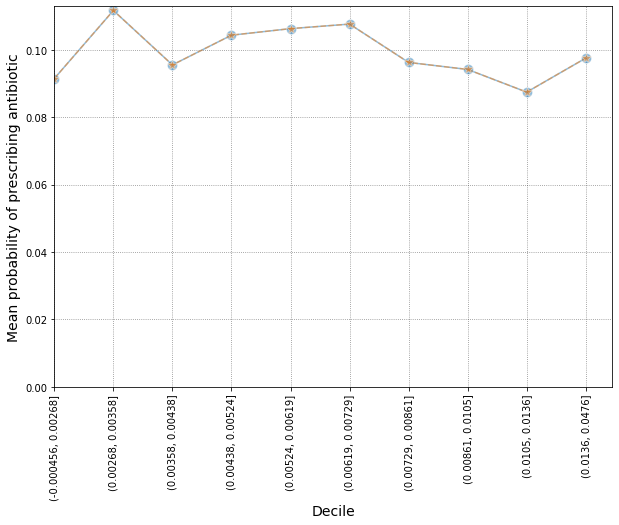


AUROC of LR for deciles with development and validation data: 0.52830 and 0.48644
AUROC of RF for deciles with development and validation data: 0.55298 and 0.48648
LR coefficients:
                                  OR  Lower CI  Upper CI
bins_(-0.000456, 0.00268]  0.088760  0.070334  0.112013
bins_(0.00268, 0.00358]    0.120062  0.097804  0.147384
bins_(0.00358, 0.00438]    0.095717  0.077171  0.118721
bins_(0.00438, 0.00524]    0.105240  0.085563  0.129443
bins_(0.00524, 0.00619]    0.110282  0.090110  0.134970
bins_(0.00619, 0.00729]    0.113659  0.093280  0.138491
bins_(0.00729, 0.00861]    0.096405  0.078194  0.118858
bins_(0.00861, 0.0105]     0.111609  0.091436  0.136233
bins_(0.0105, 0.0136]      0.097197  0.078926  0.119697
bins_(0.0136, 0.0476]      0.109907  0.090379  0.133654
antibacterial_brit         1.040518  0.993152  1.090144

RF feature importance:
                             rf_coef
antibacterial_brit         0.610234
bins_(0.00268, 0.00358]    0.076879
bins_(-0.000

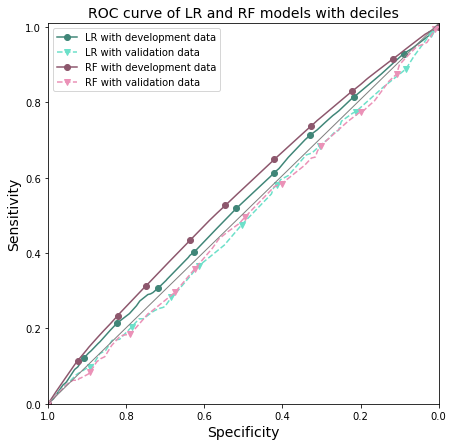

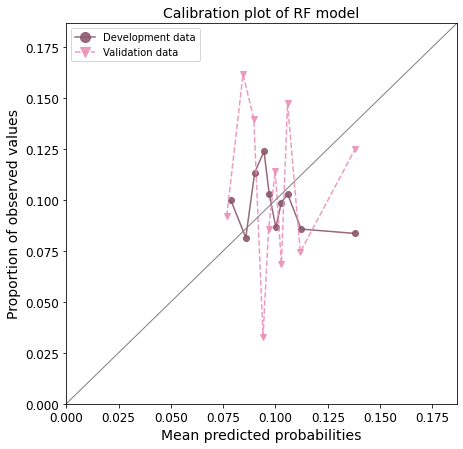

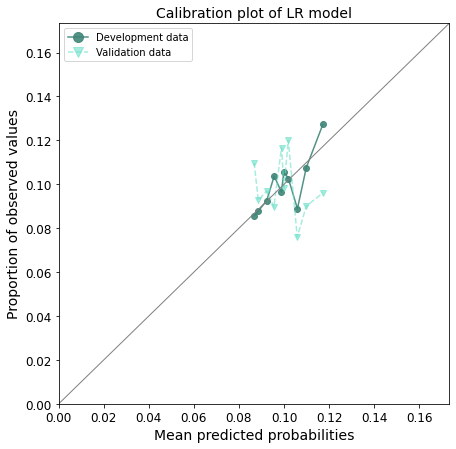

In [58]:
#build cox model for hosp prediction using non ab users' data
prob_pred_urti_combined_no_abs_prevl_post_2nd_lockdown, prob_pred_urti_combined_no_abs_prevl_post_2nd_lockdown_bin = cox_build('urti_combined', 'prevl_post_2nd_lockdown', data_urti_combined_prevl_post_2nd_lockdown, data_urti_combined_no_abs_prevl_post_2nd_lockdown)

#build rf and lr models
prob_pred_enc_lr_rf_prevl_post_2nd_lockdown, data_enc_dev_prevl_post_2nd_lockdown, data_enc_val_prevl_post_2nd_lockdown, lr_pred_dev_prevl_post_2nd_lockdown, lr_pred_val_prevl_post_2nd_lockdown, rf_pred_dev_prevl_post_2nd_lockdown, rf_pred_val_prevl_post_2nd_lockdown = lr_rf_build_risk_deciles('urti_combined', 'prevl_post_2nd_lockdown', prob_pred_urti_combined_no_abs_prevl_post_2nd_lockdown)

#calibration plots of rf and lr
calibration_rf_lr('urti_combined', 'prevl_post_2nd_lockdown', data_enc_dev_prevl_post_2nd_lockdown, data_enc_val_prevl_post_2nd_lockdown, lr_pred_dev_prevl_post_2nd_lockdown, lr_pred_val_prevl_post_2nd_lockdown, rf_pred_dev_prevl_post_2nd_lockdown, rf_pred_val_prevl_post_2nd_lockdown)